# Project 2 - Forecast correction

## General Oveview

### Assignment Overview

The aim of the assignment is to correct ensemble forecasts to be able to predict with more accuracy temperatures in a small region in Brussel.

We will use machine learing techniques to correct the forecasts for 2024 given past ensemble forecasts and the correspond measured temperature value at the vlinder station.

https://www.ecmwf.int/en/newsletter/166/meteorology/statistical-post-processing-ensemble-forecasts-belgian-met-service

### Data Preprocessing

We need high quality data before we can train our models. We will first analyse our target data (measured temperatures at vlinder station). We will see that some measurement are erroneous and thus remove them. We will then analyse features from the ensemble forecast and relate them to our target data to make informed choices on which features to keep for our training.

In order to visualize dependencies within our data more easily all the different ensemble forecasts are not directly merged into one dataframe, they are kept in a list of tuples (date, fc) where date is a string representing the start date of the forecast and fc is a dataframe holding the ensemble forcast.


### Used Algorithms

- Linear regression
- Random forest regression
- TBD (Nonhomogeneous Gaussian regression, NN?)

### Nice things to have
- [ ] Use pipelines to automate operations
- [x] Consumption of energy + log
- [ ] Time function (+ display number of training samples) 

### Personal notes
- We dont especially need to avoid duplicate data, we can keep it in different forecast. However we need to be carefull with data leakage (between train, validation and test set)
- [ ] Use past data pf 2024 to add to training data
- What data do we keep for selection [Feature Selection](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)?
    - Data selection will depend on algo used
    - correlation analysis/feature importance ranking/Principal Component Analysis 

- RandomForest Regressor
- Nonhomogeneous Gaussian regression
- Look at the difference from one day to the other in forecast (instead of computing absolute values)
- Include lead times?
- PCA for non linearity. (correlation matrix does only linear)
- Splitting randomly kind has an issue because two subsequent samples are related.
- Interpretation of bias variance / mean : High variance and low mean ? -> still miss by a lot on average?
- Further improvements ? (like building by week instead of cut off)

In [1]:
%pip install codecarbon
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from codecarbon import track_emissions, EmissionsTracker
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import math
import glob
import datetime
from functools import partial, reduce, wraps
from collections import defaultdict  
from itertools import chain, accumulate
import random
import operator
from abc import ABC, abstractmethod
from scipy.stats import linregress
import time as time_tool
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV, mutual_info_regression
from abc import ABC, abstractmethod
random.seed(42)
# 0 degre Celius in Kelvin
C_0 = 273.15
#Dict to link target metrics from forecast with an eventual required scaling constant
Const_Conversion = {'t2m' : C_0, 'd2m' : C_0, 'skt' : C_0}
plt.style.use('seaborn-v0_8-colorblind')

#from https://stackoverflow.com/questions/16739290/composing-functions-in-python
def compose (*functions):
    """
        Enables function composition
    """
    def inner(arg):
        for f in reversed(functions):
            arg = f(arg)
        return arg
    return inner

def identity(x):
    return x

# from https://realpython.com/primer-on-python-decorators/
def timer(func):

    """Print the runtime of the decorated function"""

    wraps(func)

    def wrapper_timer(*args, **kwargs):
        rows = None
        if isinstance(args[0], pd.DataFrame):
            rows = args[0].shape[0]
        start_time = time_tool.perf_counter()

        value = func(*args, **kwargs)

        end_time = time_tool.perf_counter()

        run_time = end_time - start_time

        print(f"Finished {func.__name__}() in {run_time:.4f} secs for {rows} elements")

        return value

    return wrapper_timer

# Match data sets

We will first build a class to handle ensemble forecasts.

Then we will build a class to handle Vlinder data.

Ensemble forecasts and vlinder data are both in their own class in order to be able to make queries and generate new sets of data.
This makes it easier to display data and try out multiple things.

Using those two classes we will make assumptions on the data and then match the measured temperatures to the right date in the ensemble forecast.

## Forecast data sets

Class handeling ensemble forecasts. This is done to be able to create and access forecasts in a determined way as well as computing helpfull information.


- `get_ensemble_forecast(date)` gives the ensemble forecast starting at `date`.
- `get_df()` returns one dataframe with all ensemble forecasts where forecasts are indexed by their starting date

In [3]:
# Create of Main DataFrame
class EnsembleForecast:
    def __init__(self):
        self.df = self._create_df()

    def _extract_datetime(self, file_name):
        """
            Extracts datetime object from file_name 
            Returns datetime if successful, None otherwise
        """
        try:
            strings_of_date = file_name.replace('.', '_').split('_')[1:4]
            d, m, y = tuple(map(int, strings_of_date))
            return datetime.datetime(y, m, d)
        except Exception as e:
            print(f"Forecast csv does not respect date_month_year.csv format: {e}\n {file_name} dropped")
        return None

    def _create_df(self):
        """
            Creates dataframe where each ensemble forecast is accessible by its start date
        """
        df_f = pd.DataFrame()
        for file_name in glob.glob("forecast/"+'*.csv'): 
            start_time = self._extract_datetime(file_name)
            if start_time != None:
                to_add = pd.read_csv(file_name)
                to_add['Start'] = start_time
                df_f = pd.concat([df_f, to_add])
            else:
                pass
        self.time_str = df_f.columns.to_list()[0]
        df_f = df_f.sort_values(by='Start', kind='mergesort')
        return df_f.set_index(['Start', 'time']).sort_index()

    def get_df(self):
        return self.df

    def get_min_max(self):
        """
            Returns earliest and latest date available in the ensemble forecasts
        """
        select_time = self.df.index.get_level_values('time')
        return (select_time.min(), select_time.max())
        
    def get_start_dates(self):
        """
            Returns a list start date of ensemble forecast
        """
        lst = list(set(self.df.index.get_level_values('Start')))
        lst.sort()
        return lst

    def get_ensemble_forecast(self, date):
        """
            Returns ensemble forecast given date
            date format (%Y-%M-%D %h:%m:%s)
        """
        return self.df.loc[date]

forecast_data = EnsembleForecast()

forecast_min, forecast_max = forecast_data.get_min_max()

df_1 = forecast_data.get_ensemble_forecast("2023-03-01 00:00:00")
df_all = forecast_data.get_df()
print(forecast_data.get_min_max())
df_all.to_csv('tmp.csv')

('2023-02-01 00:00:00', '2023-07-07 00:00:00')


## Vlinder Data

Vlinder data set is inside a Vlinder class. This makes it easier to query and display subsets of data

We need to check for inconsitent data points in the the vlinder set and then resample it to match the ensemble forecast

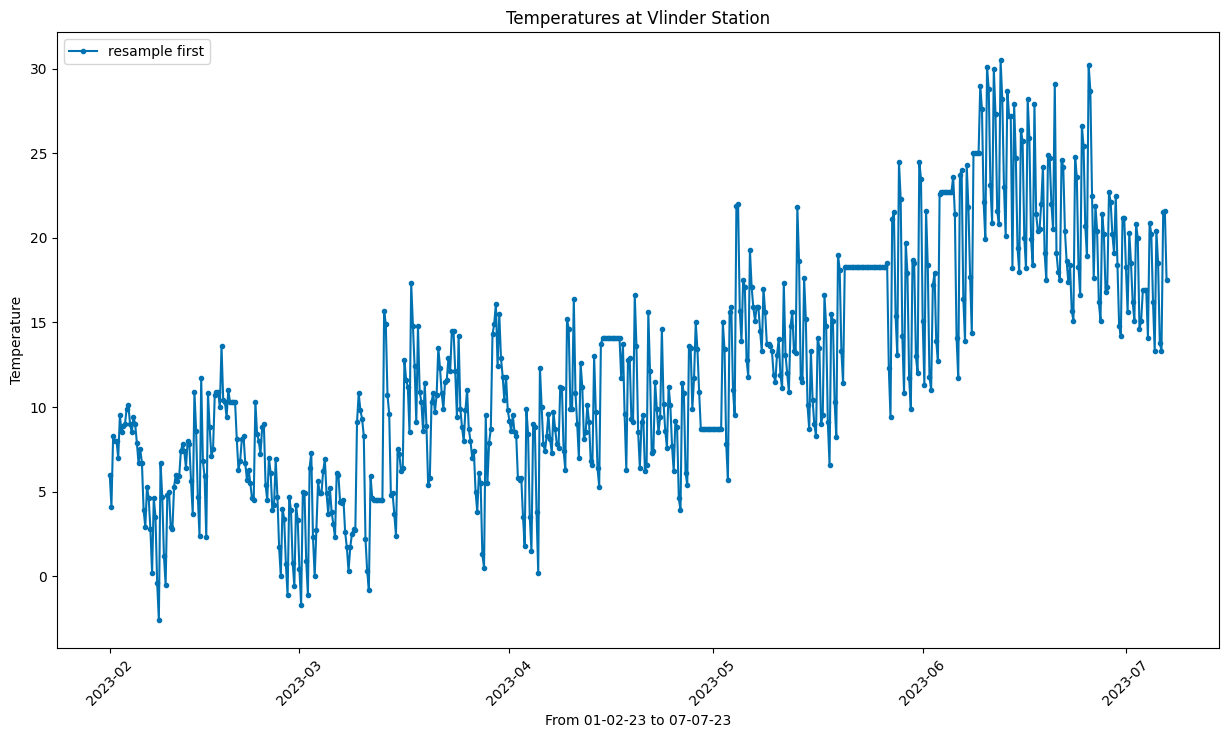

In [4]:
class Vlinder: 
    """
        Class that represents Vlinder data
        Holds original data in self.df 
        Holds resampled data in self.resample
    """
    
    def __init__(self, path_to_csv):
        self.df = pd.read_csv(path_to_csv)
        self.temp_str = self.df.columns.tolist()[0]
        self.time_str = self.df.columns.tolist()[1]
        self.df[self.time_str] = pd.to_datetime(self.df[self.time_str])
        self.resample = {"first" :  self.df.set_index(self.time_str).resample('6h').first().reset_index(),
                        "mean" : self.df.set_index(self.time_str).resample('6h').mean().reset_index()}

    def apply_dates_resize(self, first, snd):
        """
            Does a partial application of dates as we often want the same dates for different dataframes
        """
        return partial(self.resize_on_time, start=first, finish=snd)

    #TODO refactore horrible code
    def _get_time(self, df, start, finish):
        """
            Helper function to set start and finish to the min
            Start and finish can be either None, string or datetime
            Returns datetime object
        """
        if start is None: 
            start = self.earliest(df)
        elif isinstance(start, str):
            start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        else: 
            pass
        if finish is None: 
            finish = self.latest(df) 
        elif isinstance(finish, str):
            finish = datetime.datetime.strptime(finish, "%Y-%m-%d %H:%M:%S")
        else:
            pass
        return (start, finish)
        
    
    def dataframe_of_string(func):
        """
            Decorator function used to convert input dataframe string into actual dataframe
            If passed in argument is already a dataframe does nothing and passes data framethrough
            Carefull: input type is a string, new type is a dataframe
        """
        def wrapper(self, type="df", *args, **kwargs):
            if isinstance(type, str):
                type = self.select_type(type)
            return func(self, type, *args, **kwargs)
        return wrapper

    #Does not work well when chaining decorators together => Unused atm
    def handle_time(func):
        """
            Decorator used to handle start and finish times
        """
        def wrapper(self, *args, **kwargs):
            if start is None:
                start = self.earliest()
            if finish is None:
                finish = self.latest()
            return func(self, df, start, finish, *args, **kwargs)
        return wrapper

    
    def select_type(self, type="df"):
        """
            Returns dataframe corresponding to type
            types available: 
            - df : original dataframe
            - mean : dataframe resampled on mean
            - first : dataframe resampled on first
        """
        df = None
        match type:
            case "df":
                df = self.df
            case "mean":
                df = self.resample["mean"]
            case "first":
                df = self.resample["first"]
            case _ :
                raise ValueError(f"dataframe {type} does not exist")
        return df
    
    @dataframe_of_string
    def earliest(self, type="df"):
        """
            Returns earliest date in dataframe
        """
        return min(type[self.time_str])

    @dataframe_of_string
    def latest(self, type="df"):
        """
            Returns latest date in dataframe
        """
        return max(type[self.time_str])

    def plot(self, start=None, finish=None):
        """
            Plots original data points as well as resampeled on mean and first
        """
        start , finish = self._get_time(self.df, start, finish)

        # partial application of dates
        select_df = self.apply_dates_resize(start, finish)

        mean = select_df("mean")
        first = select_df("first")
        base = select_df("df")
        
        plt.figure(figsize=(15, 8))
        plt.plot(first[self.time_str], first[self.temp_str], label='resampled first', marker='o', markersize=2, linewidth=1)
        plt.plot(mean[self.time_str], mean[self.temp_str], label='resampled mean',  marker='s', markersize=2, linewidth=1)
        #plt.plot(base[self.time_str], base[self.temp_str], label='original', linestyle='--', linewidth=0.7)
        plt.legend(loc='upper left')
        plt.xlabel(f"""From {start.strftime("%d-%m-%y")} to {finish.strftime("%d-%m-%y")}""")
        plt.ylabel('Temperature')
        plt.title(f'Temperatures at Vlinder Station')
        plt.xticks(rotation=45)
        plt.show()
    
    @dataframe_of_string
    def plot_one(self, type="df", start=None, finish=None, info="df"):
        """
            Plots one of the dataframes, either df, mean or first
        """
        start , finish = self._get_time(type, start, finish)
        df_resize = self.resize_on_time(type, start, finish)
        plt.figure(figsize=(15, 8))
        plt.plot(df_resize[self.time_str], df_resize[self.temp_str], marker='o',  markersize=3, label=info) #cannot use type as label as it has been changed to dataframe through decorator
        plt.legend(loc='upper left')
        plt.xlabel(f"""From {start.strftime("%d-%m-%y")} to {finish.strftime("%d-%m-%y")}""")
        plt.ylabel('Temperature')
        plt.title(f'Temperatures at Vlinder Station')
        plt.xticks(rotation=45)
        plt.show()

    @dataframe_of_string
    def resize_on_time(self, type="df", start=None, finish=None):
        """
            Returns new data frame with values between start and finish
            type specifies on which dataframe to apply resizing (df for original, mean for resample mean and first for resample first)
            Format (%Y-%M-%D %h:%m:%s)
            
            On why start and finish = None: https://stackoverflow.com/questions/1802971/nameerror-name-self-is-not-defined
        """
        start , finish = self._get_time(type, start, finish)
        assert start >= self.earliest(type), f"{start} does not exist in dataframe"
        assert finish <= self.latest(type), f"{finish} dies not exist in dataframe"
        return type[(type[self.time_str] >= start) & (type[self.time_str] <= finish)]  

    @dataframe_of_string
    def drop_between(self, type="df", start=None, finish=None):
        """
        Drops values between [start, finish].
        If string is passed, returns new dataframe with dropped values.
        If dataframe is passed, exculdes values from that dataframe
        """
        start , finish = self._get_time(type, start, finish)
        before = type[type[self.time_str] < start]
        after = type[type[self.time_str] > finish]
        return pd.concat([before, after])

    @dataframe_of_string
    def get_cst_intervals(self, type="df"):
        """
            Returns start, end and timedelta of all constant intervals in passed dataframe
        """
        #from https://stackoverflow.com/questions/66684957/is-there-a-faster-way-for-finding-the-range-of-constant-values-in-a-dataframe
        #Compares current element with prev, if (not equal) => True (1), else False (0). cumulative sum then adds.
        #If different sum goes up, else stays constant
        df = type
        groupr = df.temp.ne(df.temp.shift()).cumsum()
        #creates group of (nb, timestamp)
        mapper = list(zip(groupr, df.datetime))
        #from https://stackoverflow.com/questions/71945206/keep-duplciate-items-in-list-of-tuples-if-only-the-first-index-matches-between-t
        dct = defaultdict(list)
        for tup in mapper:
            first, _ = tup
            dct[first].append(tup)
            onlydups = [lst for firstelem, lst in dct.items() if len(lst) > 1]
        #only dups is a list of list with duplicate items
        min_max_lst = []
        for dup in onlydups:
            start = dup[0][1]
            end = dup[-1][1]
            min_max_lst.append((start, end, end - start))
        return min_max_lst

    @dataframe_of_string
    def drop_cst(self, type="df", max_delta=6):
        """
            Keeps all constant time intervals that are stricly bigger than max_delta
            Computes const values through get_cst_intervals
        """
        df = type
        min_max_lst = self.get_cst_intervals(df)
        for timestamps in min_max_lst:
            fst = str(timestamps[0])
            snd = str(timestamps[1])
            delta = (pd.to_datetime(snd) - pd.to_datetime(fst)) / np.timedelta64(1, 'h')
            if (delta > max_delta):
                df = vlinder_data.drop_between(df, start=fst, finish=snd)
        return df

vlinder_data = Vlinder('vlinder19_2023.csv')

#Plot vlinder data on time frame of forecast date avaiable
vlinder_data.plot_one(type="first", start=forecast_min, finish=forecast_max, info="resample first")

We can see from our resampled data that there are multiple periods where temperature seems to be constant. This probably indicates a measument error. We will exclude all those inadequat values from our data.

We compute all constant time intervals through the function `get_cst_intervals()`. We can then drop them by calling `drop_cst(df, max_delta)`, `max_delta` representing consecutive constant time intervals to keep (-> if max_delta = 6, we keep all intervals that are constant on 6hours intervals or less).

We do this because it might be possible that by chance, measured temperatures on consecutive time intervals are the same. However a too long constant interval probably indicates a measurement error.

It is usefull to see what are the most common intervals where const values appear.

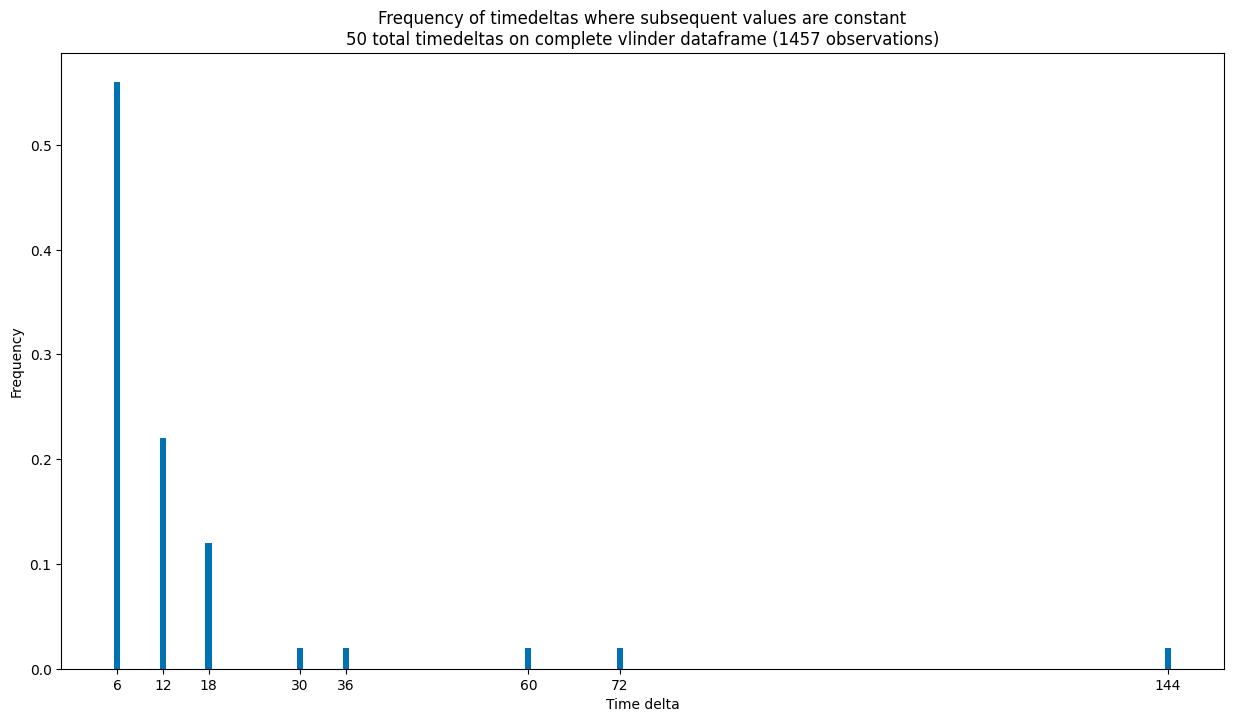

In [5]:
cst_intervals_first = vlinder_data.get_cst_intervals("first")
total_obs = len(vlinder_data.select_type("first"))
# makes list of time deltas
time_delta = list(map(lambda x : x[2], cst_intervals_first))
time_delta_to_hours = (list(map(lambda x : x.total_seconds() / 3600, time_delta)))
total_cst_elements = len(time_delta)
time, occ = np.unique(time_delta_to_hours, return_counts=True)
occ = list(map(lambda x : x / len(time_delta), occ))
plt.figure(figsize=(15, 8))
plt.bar(time, occ)
plt.xlabel('Time delta')
plt.ylabel('Frequency')
plt.xticks(time)
plt.title(f'Frequency of timedeltas where subsequent values are constant\n{total_cst_elements} total timedeltas on complete vlinder dataframe ({total_obs} observations)')
plt.show()

In [6]:
print(occ[0] + occ[1]) 

0.78


Intervals of 6 and 12 hours where consecutive values are constant represent 78% of our total time deltas. It might be probable that by random chance two intervals within 12 hours are similar. (6 hours means 2 consecutive values, 12 hours means 3 consecutive values).

NOTE: when running different models, best results where achieved when max_delta = 0 (no constant intervals are kept). Correlation between `t2m` (temperature at 2 meters from ensemble forecast) and `temp` (measured temperature at station) is also highest when max_delta = 0. Those are not are really accurate method of drawing conclusions, we should do Hypothesis testing to see what conculusions we can draw.

`drop_cst(max_delta)` is a function that drops all time intervals bigger than its given argument

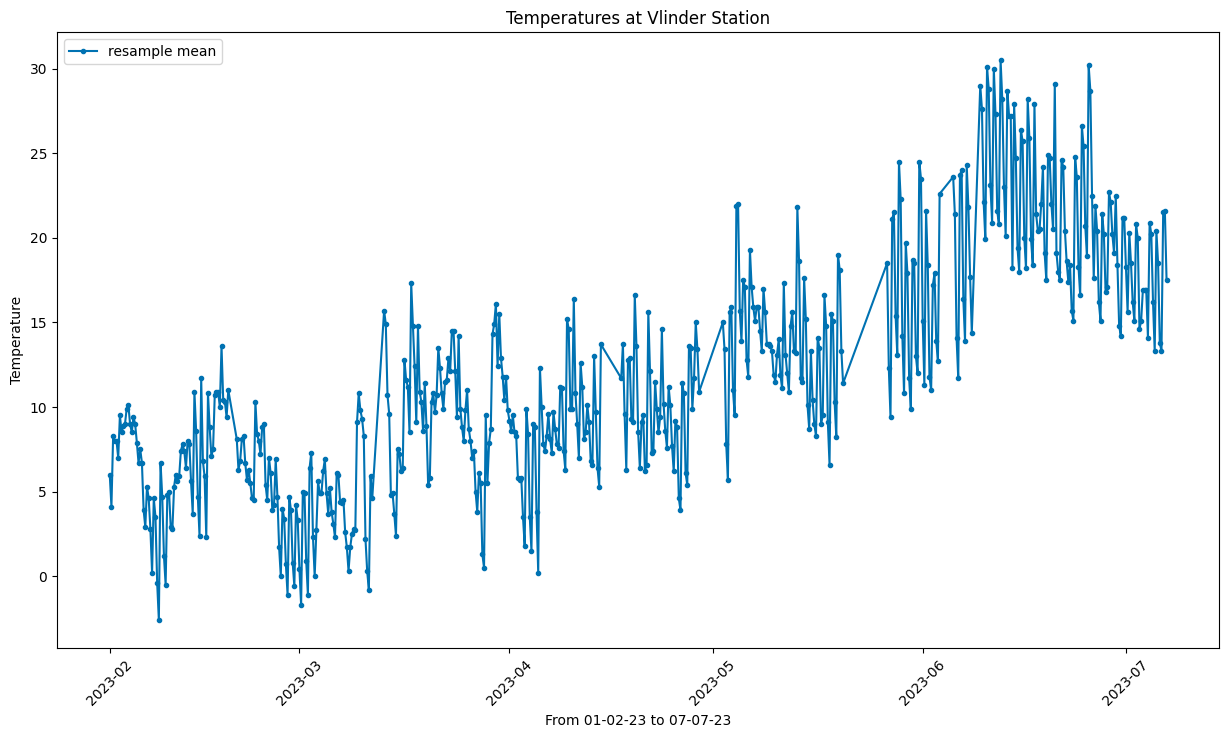

In [7]:
df = vlinder_data.resize_on_time("first", start=forecast_min, finish=forecast_max)
df = vlinder_data.drop_cst(df, 12)
vlinder_data.plot_one(df, info="resample mean")

Partial function application to select what vlinder data we should keep.

In [8]:
drop_const_p = partial(vlinder_data.drop_cst, max_delta=0)

## Integrating Forecast and Vlinder Temperaturs
1. We need to know how to resample our Vlinder Data.
   - Compute the mean of 't2m' (which will be our explanatory variable) and correlated it to the ressampled vlinder data. We then choose the highest correlated resampling method
2. We can then merge ensemble forecasts with observed vlinder data

### 1. Selection of resampling technique

We need to decide whether the mean or the first value is the right choice when resampling our Vlinder Data.
We compute correlation between the mean temperature (t2m) in the forecasts and the temperature at the vlinder station.

In [9]:
target = 't2m'

ensmean_forecast = forecast_data.get_df().groupby('time')[target].mean().reset_index()
ensmean_forecast[target] = ensmean_forecast[target] - Const_Conversion[target]
ensmean_forecast['time'] = pd.to_datetime(ensmean_forecast['time'])
ensmean_min, ensmean_max = forecast_data.get_min_max()

resize_vlinder = vlinder_data.apply_dates_resize(forecast_min, forecast_max)

dropped_vlinder_mean = drop_const_p(resize_vlinder("mean"))
dropped_vlinder_first = drop_const_p(resize_vlinder("first"))

merge_p = partial(pd.merge, left_on=forecast_data.time_str, right_on=vlinder_data.time_str)
merged_df = merge_p(ensmean_forecast, dropped_vlinder_mean).drop(columns=[vlinder_data.time_str]).rename(columns={vlinder_data.temp_str: 'mean'})
merged_df = merge_p(merged_df, dropped_vlinder_first).drop(columns=[vlinder_data.time_str]).rename(columns={vlinder_data.temp_str: 'first'})

correlation_mean = merged_df['t2m'].corr(merged_df['mean'])
correlation_first = merged_df['t2m'].corr(merged_df['first'])

print(correlation_mean, correlation_first)

0.9480840831965944 0.976521388963622


We can see that resampling on first value found in the interval has a higher correlation with our main target value 't2m'. We will use this resampling technique from now on.

### 2 Merging ensemble forecasts and vlinder temperatures

We will keep all ensemble forecasts inside a list and not merge them directly inside a unique dataframe. This helps with visualization of data as well as making it easier to target individual ensemble forecasts. It also makes it more flexible to select certain dataframes in case we dont want them for some reason. This will come up handy later. We can easily do operations on those dataframes using list processing techniques such as map, reduce and partial application.

In [10]:
def create_ens_fc_list():
    """
        Creates a list of tuples containing (start_date : string, ensemble forecast: dataframe). 
        All ensemble forecast dataframes are augmented with the respective vlinder data.
        This means that some dataframes may contain less predictions as the corresponding vlinder measurement was unusable
    """
    # get list of starting dates of ensemble forecasts
    starting_dates = forecast_data.get_start_dates()
    
    # get corresponding vlinder data with constant values dropped as decided by drop_const_p
    vlinder_temp =  drop_const_p(resize_vlinder("first"))

    dfs = []
    for date in starting_dates:
        df = forecast_data.get_ensemble_forecast(date).reset_index()
        df[forecast_data.time_str] = pd.to_datetime(df[forecast_data.time_str])
        df = pd.merge(df, vlinder_temp, left_on=forecast_data.time_str, right_on=vlinder_data.time_str)
        df.drop(columns=vlinder_data.time_str, inplace=True)
        # We need to redefine date here as the inital date could be dropped because it does not exist in the vlinder set
        # This might create data frames with the same starting date.
        date = df['time'][0]
        # if a duplicate date exists we keep the dataframe which has the most elements
        current_dates = list(map(lambda tp: tp[0], dfs))
        if date in current_dates:
            index = current_dates.index(date)
            # if the current dataframe contains more info than the current one in the list
            if (len(df) > len(dfs[index][1])): 
                # we remove element at that index
                dfs.pop(index)
        
        dfs.append((date, df))
    
    return dfs


#Some utility functions use to handle list of tuples generated by previous function
def nb_observation(df):
    return len(df.index) // 50

def date_and_obs(tp):
    start, df = tp
    return (str(start), nb_observation(df))

def only_date(tp):
    date, _ = tp 
    return date

def only_df(tp):
    _, df = tp
    return df

def merge_df(df_1, df_2):
    """
        Merges two dataframes
    """
    combined_df = pd.concat([df_1, df_2], ignore_index=False)
    return combined_df

def reduce_df(dfs_list):
    """
        Reduces all dataframes from the input list into one
    """
    reduced_df = reduce(merge_df, map(only_df, dfs_list))
    return reduced_df

dfs = create_ens_fc_list();
#contains number of observation left for each time forecast
samples_per_fc = list(map(date_and_obs, dfs))
samples_per_fc

[('2023-02-01 00:00:00', 27),
 ('2023-02-03 00:00:00', 29),
 ('2023-02-05 00:00:00', 29),
 ('2023-02-07 00:00:00', 29),
 ('2023-02-10 00:00:00', 27),
 ('2023-02-13 00:00:00', 23),
 ('2023-02-15 00:00:00', 23),
 ('2023-02-17 06:00:00', 24),
 ('2023-02-20 00:00:00', 29),
 ('2023-02-22 00:00:00', 29),
 ('2023-02-25 00:00:00', 28),
 ('2023-02-27 00:00:00', 27),
 ('2023-03-01 00:00:00', 27),
 ('2023-03-02 00:00:00', 27),
 ('2023-03-03 00:00:00', 27),
 ('2023-03-07 00:00:00', 23),
 ('2023-03-10 00:00:00', 23),
 ('2023-03-13 12:00:00', 27),
 ('2023-03-15 00:00:00', 29),
 ('2023-03-17 00:00:00', 27),
 ('2023-03-19 00:00:00', 27),
 ('2023-03-22 00:00:00', 27),
 ('2023-03-25 00:00:00', 29),
 ('2023-03-28 00:00:00', 29),
 ('2023-03-30 00:00:00', 29),
 ('2023-04-03 00:00:00', 28),
 ('2023-04-05 00:00:00', 27),
 ('2023-04-08 00:00:00', 25),
 ('2023-04-10 12:00:00', 17),
 ('2023-04-13 00:00:00', 18),
 ('2023-04-17 12:00:00', 19),
 ('2023-04-18 00:00:00', 29),
 ('2023-04-20 00:00:00', 29),
 ('2023-04

Except for the forecast starting on `2023-05-20 00:00:00`, most of the forecast still have information left in them. We will remove this forecast as it does not give enough information to accurately depcit an ensemble forecast

In [11]:
#timestamp object of forecast that the least amount of info (here 4)
not_enough_info = pd.to_datetime(min(samples_per_fc, key=lambda x: x[1])[0])
not_enough_info

Timestamp('2023-05-20 00:00:00')

In [12]:
number_of_obs = reduce(lambda x, y: x + y, map(lambda tp : tp[1], samples_per_fc))
number_of_obs

1495

# Urban Heat Island effect

The urban heat island (UHI) effect explains why urban areas are warmer than rural areas. 
- Vertical buildings collect more solar radiation.
- Black construction materials have a lower albedo.
- Solar radiation is not reflected directly back up to the atmospher due to the 3D nature of streets.
- Temperatures are not lowered by Evapotranspiration or evaporation or shaded areas.
- Nearby human activity concentration (Combustion gases, air-conditioning...) also increases temperatures
[Source](https://environnement.brussels/citoyen/outils-et-donnees/etat-des-lieux-de-lenvironnement/climat-etat-des-lieux#cartographie-des-ilots-de-fraicheur-bruxelles)

UHI is:
- stronger at night
- stronger when winds are weak
- stronger under block conditions
- affected by the surroundings, being weaker around vegetation.
- affected by cloud cover


[src2](https://en.wikipedia.org/wiki/Urban_heat_island), [src1](https://earthscience.stackexchange.com/questions/2186/is-the-urban-heat-island-effect-stronger-during-a-particular-season-or-part-of-t)

We can see this Urban Heat Island effect appear when plotting the bias between our ensemble forecast and the measured temperature at the vlinder station.

We will try here to take the heat island effect into consideration, creating new features that might produce a better represention of the underlying problem.

# Analysis of relation between target temperature and ensemble forecasts

We will first analyse the difference between the measured temperature at the vlinder station and the t2m variable (= bias of our ensemble forecast) to see if there are any difference thourghout the year. Does the forecast overshoot or undershoot the measured data depending on season of the year? 
This will help understanding the UHI and also select the right way of splitting our data (if no patterns appear throughout the year, we can split chronologically)

This analysis will also help to remove outliers in our data. We will find relative errors with abnormal variance/mean.

In [13]:
df_diff = create_ens_fc_list()

def keep_columns(to_keep, df):    
    return df[to_keep]

def group_time(df):
    mean_fc = df.groupby('time').mean()
    mean_fc['t2m'] = mean_fc['t2m'] - C_0
    return mean_fc

def diff_tm2_tmp(df):
    df['diff'] = df['temp'] - df['t2m']
    return df

def create_mean(df):
    """
        Creates column holding mean of difference 
        Requires that diff column has already been computed
    """
    df['mean_diff'] = df['diff'].mean()
    return df

keep_cols = partial(keep_columns, ['time', 't2m', 'temp'])

operations = compose(create_mean, diff_tm2_tmp, group_time, keep_cols, only_df)

list_df_diff = list(map(operations, df_diff))

For each forecast we will compute the mean and the variance of the relative error. This will show extreme values we can then remove. We will also verify if there are trends on a seasonal basis, this will help to split the data into different splits later.

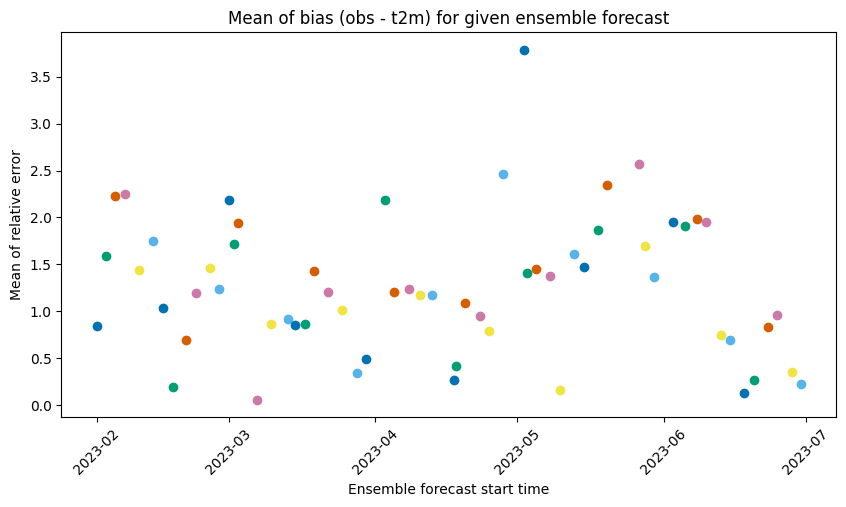

In [14]:
def compute_variance(target, df):
    """
        Computes variance on columns for given dataframe
    """
    df[f'{target} var'] = df[target].var()
    return df

def scatter_list_var(df_lst, on='diff var', ylabel='missing label', title="missing title"):
    """
        Plots all dataframes in list given as argument on parameter passed as argument
    """
    
    plt.figure(figsize=(10, 5))
    for df in df_lst:
        start = df.index[0]
        df = df.reset_index()
        plt.scatter(df[forecast_data.time_str], df[on].values, label=start)
    #plt.legend(title="Ensemble forecast starting times", loc='upper center', bbox_to_anchor=(0.5, -0.20), ncols=6)
    plt.ylabel(ylabel)
    plt.xlabel('Ensemble forecast start time')

    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

scatter_list_var(list(map(lambda df : df.iloc[[0]], list_df_diff)), on='mean_diff', ylabel='Mean of relative error', title='Mean of bias (obs - t2m) for given ensemble forecast')

Bias seems constant during the year. We can see that our relative error is always positive, this means that obs > t2m, which means that our ensemble forecast tends to predict lower temperatures than those that are measured.

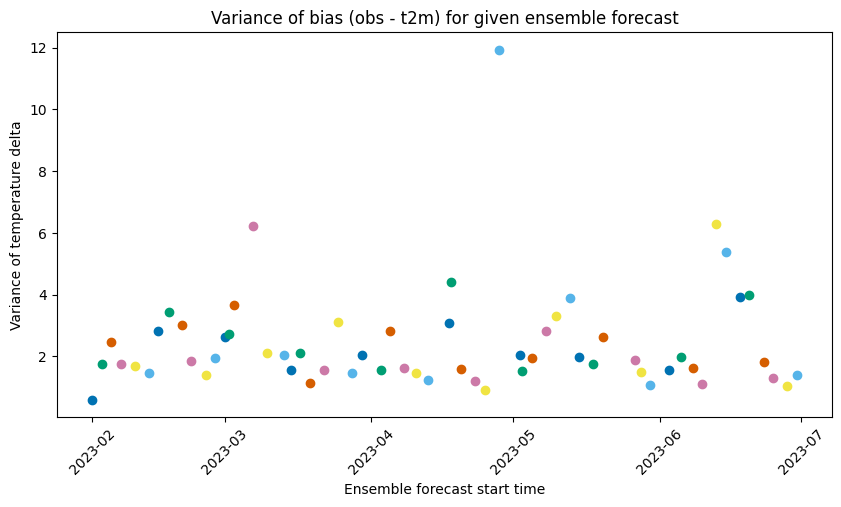

In [15]:
compute_variance_diff = partial(compute_variance, 'diff')

list_df_var = list(map(compute_variance_diff, list_df_diff))
#selects only first occurence for each ensemble forecast
diff_var_first = list(map(lambda df : df.iloc[[0]], list_df_var))
scatter_list_var(diff_var_first, on='diff var', ylabel='Variance of temperature delta',  title='Variance of bias (obs - t2m) for given ensemble forecast')

Mean and variance are looking quite constant and do not dependend on season. 
There are however a few outliers, one sample seems to be especially cold and anothers seems to have high variance (above 4). We will plot those values onto histograms to make it appear more clearly.

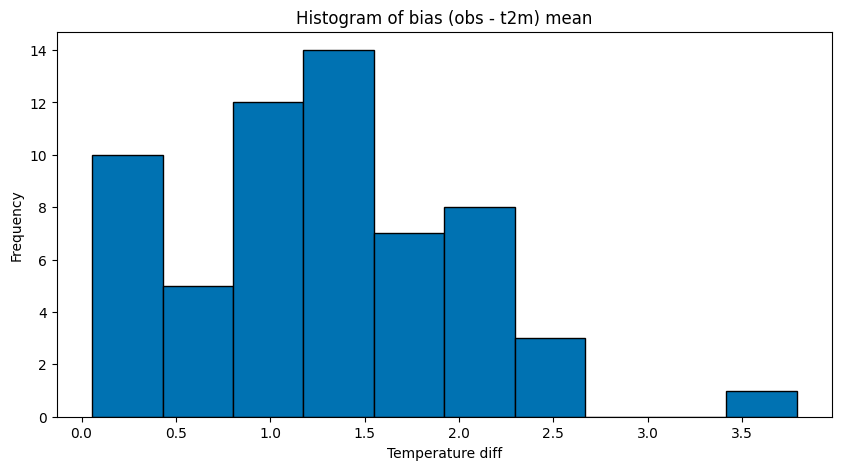

In [16]:
diff_mean = reduce(merge_df, list(map(lambda df : df.iloc[[0]], list_df_var)))

plt.figure(figsize=(10, 5))
plt.hist(diff_mean['mean_diff'], bins=10, edgecolor='black')
plt.xlabel('Temperature diff')
plt.ylabel('Frequency')
plt.title('Histogram of bias (obs - t2m) mean')
plt.show()

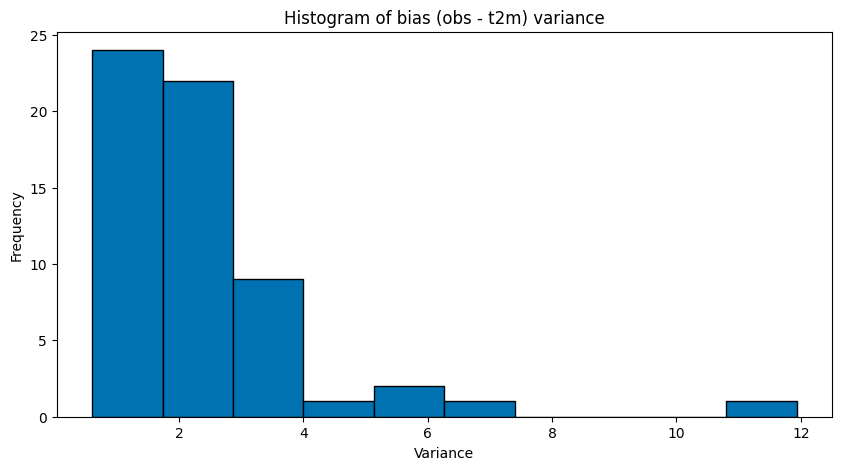

In [17]:
diff_var = reduce(merge_df, diff_var_first)

plt.figure(figsize=(10, 5))
plt.hist(diff_var['diff var'], bins=10, edgecolor='black') # Adjust bins as needed
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Histogram of bias (obs - t2m) variance')
plt.show()

We have few high variance ensemble forecasts. If we look at the time those forecast happened we can see that their are mostly during the summer. This can be explained by the heat island effect.  We will arbitrarily remove those with a variance higher than 4. We also have one forecast with mean temperature -3.5. Those are outliers that will be dropped.
We should try to predict distribution and then do some hypothesis testing to remove outliers more mathematically.

In [18]:
high_variance = diff_var[diff_var['diff var'] > 4].index.to_list()
high_mean = diff_mean[diff_mean['mean_diff'] < - 3].index.to_list()

outliers = list(set(high_variance + high_mean))
outliers

[Timestamp('2023-06-13 00:00:00'),
 Timestamp('2023-06-15 00:00:00'),
 Timestamp('2023-04-18 00:00:00'),
 Timestamp('2023-03-07 00:00:00'),
 Timestamp('2023-04-28 00:00:00')]

We also mentionned earlier that the UHI is stronger at night, we will plot the difference between the forecasted temperature and the observed temperature by measurement instants.

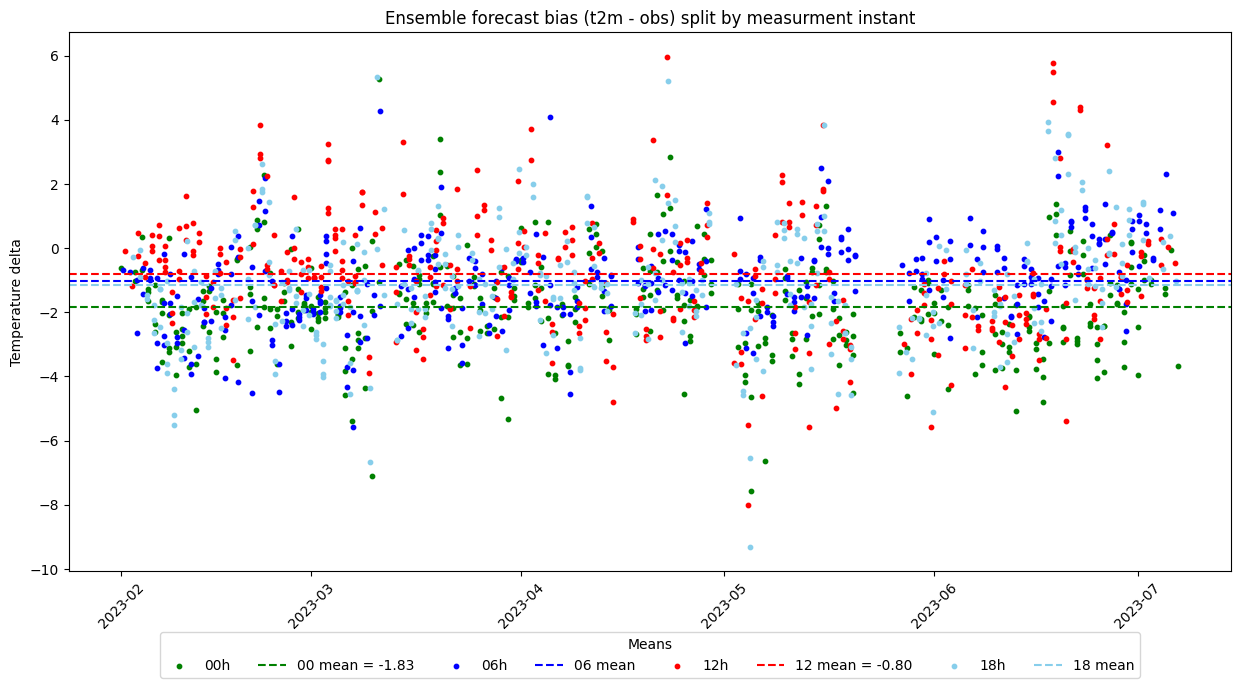

In [19]:
def compute_bias(df):
    """
        Computes bias for each lead time in a given dataframe
    """
    df['delta'] = df['t2m'] - (df['temp'] + C_0)
    return df

def group_mean_time(df): 
    """
        Groups by mean on 'time'
    """
    return df.groupby('time').mean()
    


df_all = create_ens_fc_list()

operations = compose(group_mean_time, compute_bias , only_df)

df_all = list(map(operations, df_all))

df_all = reduce(merge_df, df_all)

df_all = df_all.reset_index()
df00 = df_all[df_all['time'].dt.time == pd.Timestamp('00:00:00').time()]
df06 = df_all[df_all['time'].dt.time == pd.Timestamp('06:00:00').time()]
df12 = df_all[df_all['time'].dt.time == pd.Timestamp('12:00:00').time()]
df18 = df_all[df_all['time'].dt.time == pd.Timestamp('18:00:00').time()]

plt.figure(figsize=(15, 7))
plt.scatter(df00['time'], df00['delta'], label='00h', color="green", s=10)
plt.axhline(y=df00['delta'].mean(), color='green', linestyle='--', label=f"00 mean = {df00['delta'].mean():.2f}")
plt.scatter(df06['time'], df06['delta'], label='06h', color="blue", s=10)
plt.axhline(y=df06['delta'].mean(), color='blue', linestyle='--', label='06 mean')
plt.scatter(df12['time'], df12['delta'], label='12h', color="red", s=10)
plt.axhline(y=df12['delta'].mean(), color='red', linestyle='--', label=f"12 mean = {df12['delta'].mean():.2f}")
plt.scatter(df18['time'], df18['delta'], label='18h', color="skyblue", s=10)
plt.axhline(y=df18['delta'].mean(), color='skyblue', linestyle='--', label='18 mean')
plt.ylabel('Temperature delta')
plt.title('Ensemble forecast bias (t2m - obs) split by measurment instant')
plt.legend(title="Means", loc='upper center', bbox_to_anchor=(0.5, -0.10), ncols=8)

plt.xticks(rotation=45)
plt.show()

We can indeed see here that the observed temperatures seem to be relatively warmer at night, the measured temperature seems to be closer to the observed temperature at noon and both middle measurements (6h and 18h) are relatively close together.
What we can also see is that during the summer months it tends to be even warmer 

We will encode this categorical data by using cyclical encoding. We will also add wind_speed as a feature as well as lead time.

In [20]:
def add_features_uhi(df):
    """ 
        Adds all features required for uhi prediction
    """
    df = df.reset_index()
    df['temp'] = df['temp'] + C_0
    df['bias'] = df['t2m'] - (df['temp'] + C_0)
    df['wind_speed'] = np.sqrt(df['v10'] ** 2 + df['u10'] ** 2)
    df['time'] = pd.to_datetime(df['time'])
    df['sin_hour'] = np.sin(2 * np.pi * df['time'].dt.hour / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['time'].dt.hour / 24)
    df = df.assign(leadtime=lambda x: x.index * 6)
    return df

df_analysis_list = create_ens_fc_list()
operations = compose(add_features_uhi, group_mean_time , only_df)
df_analysis_list = list(map(operations, df_analysis_list))

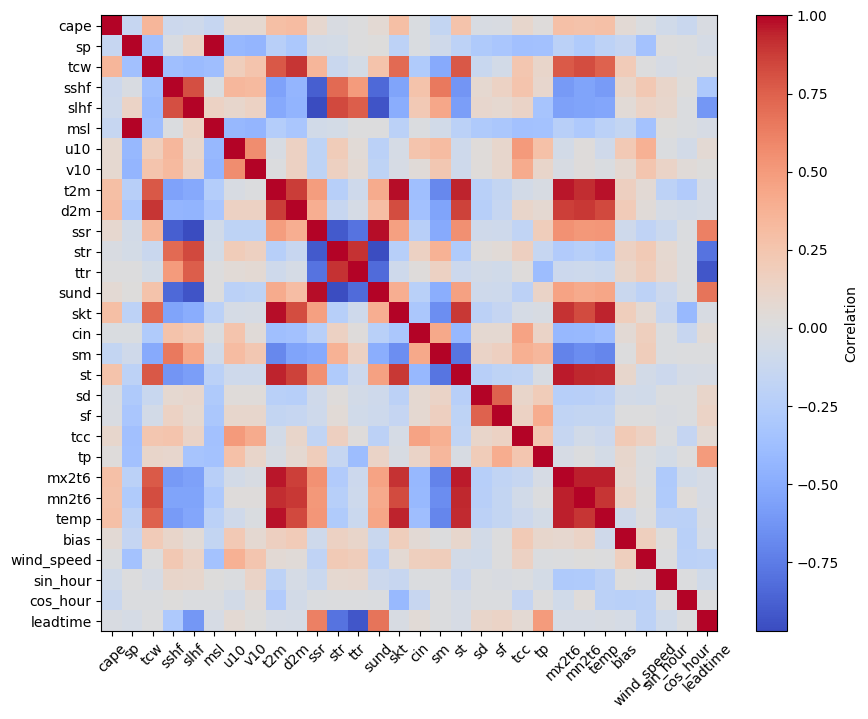

In [21]:
def display_corr_matrix(df):
    corr_matrix = df.corr() 
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest') 
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
    plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
    plt.colorbar(label='Correlation')
    plt.show()

df_analysis_corr = reduce(merge_df, df_analysis_list).drop(columns=['number', 'latitude', 'longitude', 'time'])
display_corr_matrix(df_analysis_corr)

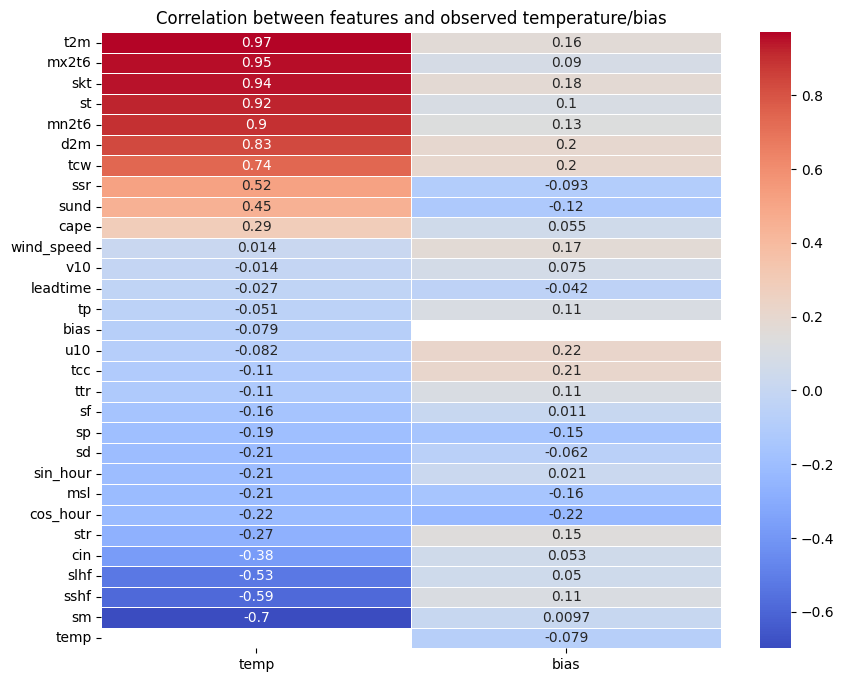

In [22]:
correlations_temp = df_analysis_corr.corr()['temp'].drop('temp')
correlations_delta = df_analysis_corr.corr()['bias'].drop('bias')
temp_corr_df = pd.DataFrame({'temp': correlations_temp, 'bias': correlations_delta})
temp_corr_df = temp_corr_df.sort_values(by=temp_corr_df.columns[0], ascending=False)
plt.figure(figsize=(10, 8))
sns.heatmap(temp_corr_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between features and observed temperature/bias')
plt.show()

Without surprise we can see from the correlation matrix that the features from the ensemble forecast that are highly correlated with the vlinder temperature are those measuring some kind of temperature (skt, t2m, d2m, mx2t6, mn2t6,..). 
But those features are also heavily correlated with each other as they represent the same thing. They therefore might not convey usefull additional information.

Having correlated features is called multicollinearity. 

Having multicollinearity is an issue for certain ml models, and not for others. However removing multicollinearity helps with explanability of our models. [src](https://hackernoon.com/multicollinearity-and-its-importance-in-machine-learning).

The first non temperature related temperature is `tcw` (= total column water). Soil moisture (`sm`) is also an interesing negative value.

We will do principal component analysis to try to reduce 

Additionaly this only shows linear correlation. We will compute mutual information to try to find non linear relations.

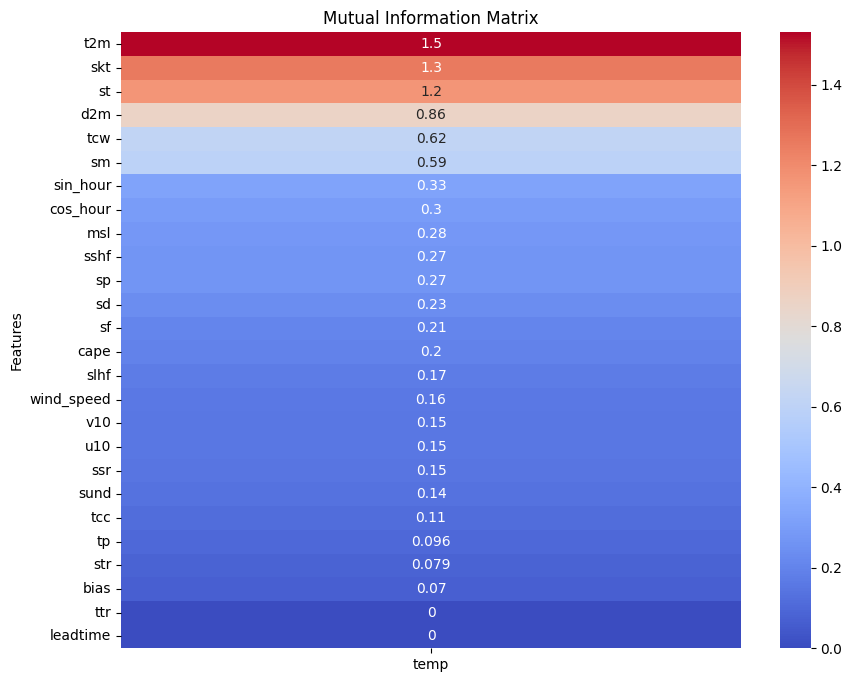

In [23]:
df_mutual_info = df_analysis_corr.drop(columns=['temp', 'cin', 'mx2t6', 'mn2t6'])
mutual_info = mutual_info_regression(df_mutual_info, df_analysis_corr['temp'])

df_mutual_info = pd.DataFrame({'temp': mutual_info}, index=df_mutual_info.columns).sort_values(by='temp', ascending=False)
plt.figure(figsize=(10, 8))
sns.heatmap(df_mutual_info, annot=True, cmap="coolwarm")
plt.title("Mutual Information Matrix")
plt.ylabel("Features")
plt.show()

# Splitting Train, Validation and Test sets

As we want to train multiple models to see which has the best outcomes we want to split our data. We will do so by keeping ensemble forecasts together by starting date. Some ensemble forecast will be used to train the models, other to validate and a final ensemble forecast will be used to do the final assessment. 

However we might face data leakage if we do random splitting as we have overlapping forecasts. This means that the same target variable ('t2m') might end up in a training sample and in a test sample. We need to do further analysis to verify how our data behaves and what suitable splitting techniques are. We could either: 

As variation in forecast and measurement is not dependend on time we can split on time periods, keeping forecasts together on time

Selected solution: as no pattern seems to appear with time we split the data chronologically (x first % go into train, following y% into validation and last z% into test set). We then remove overlapping values at each intersection to avoid data leakage. Selecting chronologically limits the number of overlapping values we need to drop

In [24]:
def generate_tuple(df):
    """
        Functions acting on dataframes (like one creating) UHI features 
        returns only a dataframe, but all other function need a (date, df) tuple
        We need a function to add the date again
    """
    return (df['time'][0], df)

dfs = create_ens_fc_list()

to_remove = outliers + [not_enough_info]



"""
    In the ensemble forecast list (dfs), tp[0] are timestamp objects, not strings => to_remove list should contain
    timestamp objects
"""
cleared = list(filter(lambda tp : tp[0] not in to_remove, dfs))

# add UHI features to dataframes
operations = compose(generate_tuple, add_features_uhi, group_mean_time , only_df)

cleared = list(map(operations, cleared))

assert len(cleared) + len(to_remove) == len(dfs), f"cleared list + remove list is not the same length as inital list: {len(cleared)} + {len(to_remove)} != {len(dfs)}"

def select_chronologically(dfs_list, train_p=0.6, val_p=0.2):
    """
        Selects in order of appearance: first 'train_p'% values are going into train set, following `val_p`% are going into train set 
        and rest goes into test set
        Might not be exatly split as some dataframe contain different number of observations after data cleaning
        TODO: We have a lot of overlapping data in the beggining (from 1-03 to 3-03), is this an issue?
    """
    nb_elem = len(dfs_list)
    train_index_max = int(nb_elem * train_p)
    
    train_set = dfs_list[: train_index_max]
    
    val_index_max = int(nb_elem * (train_p + val_p))
    val_set = dfs_list[train_index_max: val_index_max]
    
    test_set = dfs_list[val_index_max:]

    contains_common_elements = set(map(only_date, train_set)) & set(map(only_date, val_set)) & set(map(only_date, test_set))
    assert not contains_common_elements, "train, validation and test contain same ensemble forecast"

    return (train_set,val_set,test_set)

def select_randomly(dfs_list, train_p=0.6, val_p=0.2):
    """
        Splits randomly values from from given input dataframe list into (train_set, val_set, test_set)
        TODO: might not be exatly as dataframe contain different number of observations after data cleaning
        NOTE: not used anyway
    """
    nb_elem = len(dfs_list)
    
    nb_train_elements = int(nb_elem * train_p)
    train_set = sorted(random.sample(dfs_list, nb_train_elements), key=lambda x : x[0])

    #list of not selected elements
    rest = sorted([tp for tp in dfs if tp not in train_set], key=lambda x : x[0])

    nb_val_elements = round(nb_elem * val_p)
    
    validation_set = sorted(random.sample(rest, nb_val_elements), key=lambda x : x[0])

    test_set = sorted([tp for tp in rest if tp not in validation_set], key=lambda x : x[0])

    contains_common_elements = set(map(only_date, train_set)) & set(map(only_date, validation_set)) & set(map(only_date, test_set))
    assert not contains_common_elements, "train, validation and test contain same ensemble forecast"
    return (train_set, validation_set, test_set)

def get_unique_timestamps_set(df_list):
    """
        returns set of all timestamps of the list of dataframe passed as argument
    """
    operations = compose(lambda np_arr: np_arr.tolist(), lambda df: df['time'].unique(), only_df)
    return set(reduce(operator.concat, list(map(operations, df_list))))

def select_unique(dfs_list, train_p=0.6, val_p=0.2): 
    """
        We need to make sure that no common dates are appearing in train, validation and test set
        1. extract all unique time stamps from train, validation and test set
        2. As we select chornologically we need to check only if there is overlapping data between train-val and val-test
        3. Remove overlapping data from the earliest dataframe, (=> from train in train-val and from val in val-test). 
            -> This favors that is a bit more recent in the 
    """
    train, val, test = select_chronologically(dfs_list, train_p, val_p)
    operations = compose(lambda np_arr: np_arr.tolist(), lambda df: df['time'].unique(), only_df)
    
    #list containing sublists with all unique time stamps within a given dataframe
    unique_dates_train = get_unique_timestamps_set(train)
    uniques_dates_val = get_unique_timestamps_set(val)
    uniques_dates_test = get_unique_timestamps_set(test)

    conflict_train_val = unique_dates_train & uniques_dates_val
    conflict_val_test = uniques_dates_val & uniques_dates_test
    
    # Removes conflicting values from train and validation sets
    train = list(map(lambda tp: (tp[0], tp[1][~tp[1]['time'].isin(list(conflict_train_val))]), train))
    val = list(map(lambda tp: (tp[0], tp[1][~tp[1]['time'].isin(list(conflict_val_test))]), val))
    
    return (train, val, test)

train_set, val_set, test_set = select_unique(cleared)

unique_dates_train = get_unique_timestamps_set(train_set)
unique_dates_val = get_unique_timestamps_set(val_set)
unique_dates_test = get_unique_timestamps_set(test_set)

# making sure that no timestamp exists in muliple sets
assert len(cleared) == len(train_set) + len(val_set) + len(test_set), f"Inital list and sum of generated list do not have the same number of elements {len(cleared)} != {len(train_set)} + {len(val_set)} + {len(test_set)}"
assert len(unique_dates_train & unique_dates_val) == 0, f"Train and validation sets contain same dates {unique_dates_train & unique_dates_val}"
assert len(unique_dates_val & unique_dates_test) == 0, f"Val and Test sets contain same dates {unique_dates_val & unique_dates_test}"
assert len(unique_dates_train & unique_dates_test) == 0, f"Train and Test sets contain same dates {unique_dates_train & unique_dates_test}"

In [25]:
#Display columns that have NaN values and percentage of NaN values
def nan_info(df):
    for column in which_col_nan(df):
        nan_percent = get_nan_percent(df[column], df.shape[0])
        print(f"{column} has {nan_percent * 100:.2f} % of NaN values" )
        
#Returns list of Columns that have nan values
def which_col_nan(df):
    return df.columns[df.isna().any()].tolist()

def get_nan_percent(df_col, df_entries):
    return df_col.isna().sum() / df_entries

nan_info(reduce_df(train_set))

cin has 36.73 % of NaN values
mx2t6 has 3.44 % of NaN values
mn2t6 has 3.44 % of NaN values


We can see that cin has a large amount of NaN values and mx2t6 and mn2t6 have smaller amount, we will definitevely drop cin, but we could extrapolate mx2t6 it appears to be interesting.

Most of the values are actually not really relevant and our models will mainly focus on `t2m` feature

In [26]:
# Returns list of columns who have a number of unique features = 1 (=> all the same values)
# from https://studymachinelearning.com/pandas-how-to-remove-dataframe-columns-with-constant-same-values/
def constant_value_features_columns(df):
    return [e for e in df.columns if df[e].nunique() == 1]

def remove_cst_values(df):
    to_keep = [e for e in df.columns if e not in constant_value_features_columns(df)]
    return df[to_keep]

def remove_nan_values(df):
    na_cols = which_col_nan(df)
    return df.drop(columns=na_cols, axis=1)

def clean_dfs(df_lst):
    """ 
        Takes in a LIST of [(timestamp, dataframes)]
        Applies above mentionned transformations to a list of dataframes
            - Removes columns with all const values
            - Removes columns with NaN values
        Returns only one dataframe 
    """
    reduce_merge_train = reduce(merge_df, map(only_df, df_lst))
    return clean_one(reduce_merge_train)

def clean_one(df):
    """
        Takes in a dataframe, applies transformations
        - Removes columns with all const values
        - Removes columns with NaN values
        Returns cleaned dataframe
    """
    transform_operations = compose(remove_cst_values, remove_nan_values)
    cleaned_df = transform_operations(df)
    return cleaned_df

Those clean functions are not really usefull in practice as we will mostly select features that are always complete and not constant.

# Training Models

For each model we will:
1. Clean and transform the train data to prepare it for the model
3. Fit the model
4. Try the model on validation data.
    - We might need to transform validation data aswell
    - Compute the corrected forecast values and and take the mean. We can then compare this mean to our measured temperature on the same interval

Each model will have to handle the list of dataframe, select a subset of features that it will train on. Its will also need to do hyperparameter tuning and transform the dataframe on which the correction will happen. Even if most of those operations are quite similar for each model it its best to encapsulate them in classes. This will make the code a bit more readable. We will have one abstract class representing a general model. Each model will then inherit from that class.

In [74]:
class Model(ABC): 
    
    @property
    @abstractmethod
    def name(self):
        pass

    @property
    @abstractmethod
    def model(self):
        pass
    
    @abstractmethod
    def transform_list(self, df_list: list):
        pass

    @abstractmethod
    def transform_correct_pred(self, df):
        pass
    
    @abstractmethod
    def train_model(self, X, y):
        pass

    @abstractmethod
    def predict(self, df):
        pass

def display_metrics(y_true, y_pred, expl_str):
    """
        Returns mse, mae and r2
    """
    mse, mae, r2, bias = compute_metrics(y_true, y_pred)
    # print(y_true)
    # print(y_pred)
    # print(np.sum(y_true.values.reshape(-1, 1) - y_pred))
    # print(y_true.values.shape[0])
    print(expl_str)
    print(f"mse: {mse}")
    print(f"mae: {mae}")
    print(f"r2: {r2}")
    print(f"bias: {bias}")
    return (mse, mae, r2, bias)

def compute_metrics(y_true, y_pred): 
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    bias = np.sum(y_true.values.reshape(-1, 1) - y_pred) / y_true.values.shape[0]
    return mse, mae, r2, bias

In [28]:
model_list = []

We will store all models as tuples ("modelname", model, transform function) inside the model_list.
This is done to make it easier later to evaluate the different models

## Linear Regression
"Least-squares regression is applied on training data to estimate a linear relationship between predictions and corresponding observations" from _Vannitsem, S., Wilks, D. S., & Messner, J. W. (Elsevier). (2018). Statistical Postprocessing of Ensemble Forecasts_

We will first fit a linear regression with only 't2m' as a feature.

We will then make a second linear regression with 't2m' and 'tcw' as its the second highest correlated value that is not a temperature.

### 1. Only t2m feature

In [29]:
class linearReg(Model): 
    def __init__(self):
        self._name = "Linear Regression"
        self._model = LinearRegression()

    @property
    def name(self):
        return self._name

    @property
    def model(self):
        return self._model
    
    def transform_list(self, df_list):
        df = reduce_df(df_list)
        df = df[['t2m', 'temp', 'time']]
        
        # Line to comment out group indentical values by mean
        #df = df.groupby('time').mean()
        df = df.drop_duplicates(subset='time', keep='last')
        
        df.reset_index(inplace=True)
        df.drop(columns=['index'], inplace=True)
        df.to_csv('temp.csv')
        return df

    def transform_correct_pred(self, df):
        """
            Expects as input ensemble forecast
            Returns selected features used in prediction
            Used when calling predict. 
        """
        return df['t2m'].values.reshape(-1, 1)
    
    def train_model(self, df):
        """
            Expects result from transform_list()
        """
        X = df['t2m'].values.reshape(-1, 1)
        y = df['temp'].values.reshape(-1, 1)
        self._model.fit(X, y)
        return self._model

    def predict(self, df):
        """
            Expects ensemble forecast dataframe
        """
        return self.model.predict(self.transform_correct_pred(df))

    def __str__(self):
        return f"Model(Name={self._name})"

lr = linearReg()

lr.train_model(lr.transform_list(train_set))

y_true = lr.transform_list(val_set)['temp']
y_pred = lr.predict(lr.transform_list(val_set))
mse_lr, mae_lr, r2_lr = display_metrics(y_true, y_pred, "Base Linear Reg")

model_list.append(lr)

Base Linear Reg
mse: 2.5498575611053558
mae: 1.2786158873740525
r2: 0.8565262377817782
bias: 0.886377324245323


What is interesting to see is that when taking only the latest date for each forecast (instead of computing the mean) our model does way better.

Base Linear Reg - Mean
- mse: 3.489073421883973
- mae: 1.520413160154458
- r2: 0.8036790375552215

Base Linear Reg - Latest
- mse: 2.5498575611053558
- mae: 1.2786158873740525
- r2: 0.8565262377817782

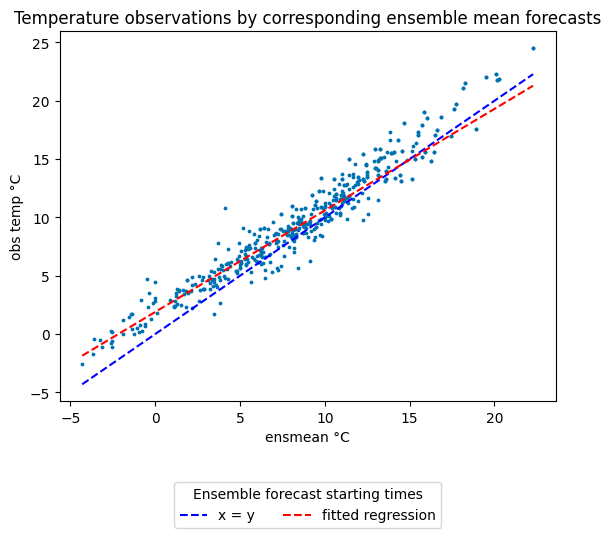

In [30]:
display = pd.concat([lr.transform_list(train_set), lr.transform_list(val_set), lr.transform_list(val_set)])

x = np.linspace(min(display['t2m'] - C_0), max(display['t2m'] - C_0))
y = x

slope = lr.model.coef_[0]
intercept = lr.model.intercept_

line = slope * np.linspace(min(display['t2m']), max(display['t2m'])) + intercept - C_0

plt.scatter(display['t2m'] - C_0, display['temp'] - C_0, marker='o', s=3)
plt.plot(x , y, linestyle='--', color='blue', label='x = y')
plt.plot(x , line, linestyle='--', color='red', label='fitted regression')
plt.legend(title="Ensemble forecast starting times", loc='upper center', bbox_to_anchor=(0.5, -0.20), ncols=6)
plt.xlabel("ensmean °C")
plt.ylabel("obs temp °C")
plt.title('Temperature observations by corresponding ensemble mean forecasts')
plt.show()

We can actually see that our linear regression is going to perform quite poorly when temperatures are higher than 5 degrees and is going to do barely better than the ensemble mean. This might because there is a higher temperature difference at lower temperatures (probably at night) which makes our regression tilt to the right. We will try to reduce this bias by trying other regression techniques such as Ridge and Lasso.

### 1. Multiple Linear Regression 

Instead of only using the ensemble mean to correct our temperatures we will add multiple other variables that also correlate highly with our target temperature 

In [31]:
class MultipleLinearReg(Model): 
    def __init__(self, features=['t2m', 'tcw', 'sm']):
        self._name = "Multiple Linear Regression"
        self._model = LinearRegression()
        self._selected_features = features;
    
    @property
    def name(self):
        return self._name

    @property
    def model(self):
        return self._model
    
    def transform_list(self, df_list):
        df = reduce_df(df_list)
        df = df[['temp', 'time'] + self._selected_features]
        #df = df.groupby('time').mean()
        df = df.drop_duplicates(subset='time', keep='last')
        df.set_index('time', inplace=True)
        return df

    def transform_correct_pred(self, df):
        """
            Expects as input ensemble forecast
            Returns selected features used in prediction
            Used when calling predict. 
        """
        return df[self._selected_features]
    
    def train_model(self, df):
        """
            Expects result from transform_list()
        """
        X = df[self._selected_features]
        y = df['temp'].values.reshape(-1, 1)
        self._model.fit(X, y)
        return self._model

    def predict(self, df):
        """
            Expects ensemble forecast dataframe
        """
        return self.model.predict(self.transform_correct_pred(df))

    def get_features(self):
        df = pd.DataFrame({'Index': self._selected_features, 'Value': self.model.coef_[0]})
        df.set_index('Index', inplace=True)
        return df

m_lr = MultipleLinearReg()
m_lr.train_model(m_lr.transform_list(train_set))

model_list.append(m_lr)

corr = m_lr.predict(m_lr.transform_list(val_set))

y_true = m_lr.transform_list(val_set)['temp']
y_pred = m_lr.predict(m_lr.transform_list(val_set))
display_metrics(y_true, y_pred, "Multiple Linear Reg")

m_lr.get_features()

Multiple Linear Reg
mse: 2.653708732790542
mae: 1.2980285143972838
r2: 0.8506828061565288
bias: 0.9064453775267765


,Value
Index,
t2m,0.867197
tcw,0.002739
sm,0.000809


What is interesting to note is that even if total cloud cover and soil moisture have a high correlation with observed temperature, their coefficient is really low. This indicates high multicolineary. We should try to find better variables.

We can again see that the best approach is to keep the latest dates for prediction. It does however not do better than simple linear regression.

Multiple Linear Reg - No duplicate dropping
- mse: 4.782626733031569
- mae: 1.7327302231447639
- r2: 0.6861883068615133

Multiple Linear Reg - Grouping by Mean
- mse: 3.5594229215412994
- mae: 1.5204834991513527
- r2: 0.7997206566872209

Multiple Linear Reg - Latest
- mse: 2.653708732790542
- mae: 1.2980285143972838
- r2: 0.8506828061565288

I choose new features here, instead of selecting values that correlated high with our observed temperature, I added the features who correlated the highest with our bias (t2m - obs)

In [33]:
m_lr_v2 = MultipleLinearReg(['t2m', 'cos_hour', 'u10'])
m_lr_v2.train_model(m_lr_v2.transform_list(train_set))

model_list.append(m_lr_v2)

corr = m_lr_v2.predict(m_lr_v2.transform_list(val_set))

y_true = m_lr_v2.transform_list(val_set)['temp']
y_pred = m_lr_v2.predict(m_lr_v2.transform_list(val_set))
display_metrics(y_true, y_pred, "Multiple Linear Reg v2")

m_lr_v2.get_features()

Multiple Linear Reg v2
mse: 1.7656372137082184
mae: 1.0843448171898085
r2: 0.9006522491188087
bias: 0.5269369109182673


,Value
Index,
t2m,0.909520
cos_hour,0.327384
u10,-0.073746


## Lasso Regression

https://www.ibm.com/topics/ridge-regression

As mentionned before, most of the values that have a high correlation with target temperature are also correlated with each other. In order to reduce this multicollinearity we can use regularization to improve our forecast.

We can either use Ridge or Lasso.

Lasso (=L1) will reduce certain features to 0 and thus perform selection. 

Ridge (=L2) will shrink down certain extreme values (but they wont be equal to 0 -> there is no feature selection).

Ridge is usefull if all our features are potentially relevant. However we already saw that there is high multicollinearity. We will use lasso regression as we have a high-dimensional set. It will perform feature selection for us.

In [78]:
class LassoReg(Model): 
    def __init__(self, features=['t2m', 'cos_hour', 'u10']):
        self._name = "Lasso Reg"
        self._model = Lasso()
        self._selected_features = features;
    
    @property
    def name(self):
        return self._name

    @property
    def model(self):
        return self._model
    
    def transform_list(self, df_list):
        df = reduce_df(df_list)
        df = df[['temp', 'time'] + self._selected_features]
        df = df.drop_duplicates(subset='time', keep='last')
        df.set_index('time', inplace=True)
        return df

    def transform_correct_pred(self, df):
        """
            Expects as input ensemble forecast
            Returns selected features used in prediction
            Used when calling predict. 
        """
        return df[self._selected_features]
    
    def train_model(self, df):
        """
            Expects result from transform_list()
        """
        X = df[self._selected_features]
        y = df['temp'].values.reshape(-1, 1)
        self._model.fit(X, y)
        return self._model

    def predict(self, df):
        """
            Expects ensemble forecast dataframe
        """
        return self.model.predict(self.transform_correct_pred(df))

    def get_features(self):
        df = pd.DataFrame({'Index': self._selected_features, 'Value': self.model.coef_[0]})
        df.set_index('Index', inplace=True)
        return df

    def tune(self, df):
        """
            Does hyper param tuning. replaces the model in the class with the tuned model
            => We can call tune and then train_model
        """
        param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
        X = df[self._selected_features]
        y = df['temp'].values.reshape(-1, 1)
        grid_search = GridSearchCV(self._model, param_grid, cv=5)
        grid_search.fit(X, y)
        #print("Best alpha:", grid_search.best_params_['alpha'])
        self._model = Lasso(alpha=grid_search.best_params_['alpha'])
         

lasso = LassoReg(features=['t2m', 'cos_hour', 'tcc', 'u10', 'd2m', 'tcw', 'sm', 'msl', 'sshf', 'ssr'])

lasso.tune(lasso.transform_list(train_set))
lasso.train_model(lasso.transform_list(train_set))


corr = lasso.predict(lasso.transform_list(val_set))

y_true = lasso.transform_list(val_set)['temp']
y_pred = lasso.predict(lasso.transform_list(val_set))
display_metrics(y_true, y_pred, "Lasso")
model_list.append(lasso)

Lasso
mse: 2.78488657170643
mae: 1.3631826895098993
r2: 0.8433017750134559
bias: 87.10897590025677


Bias is broken, but lasso regression does worse than multiple linear regression

## Random Forest Regression

In order to display information during hyperparameter tuning (displaying the diminishing returns of n_estimators) we will need an independent set, we will thus remove one of the forecasts from the train set.

#TODO: Try out by using ensemble forecast mean instead of taking all the values.

In [ ]:
random_forest_train = reduce_df(train_set).groupby('time').mean().reset_index()

y_train_rf = random_forest_train[['temp']] + C_0
X_train_rf = random_forest_train.drop(columns=['temp', 'time'])
X_train_rf = clean_one(X_train_rf)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

#should check by also adding tcw as a value
selector = SelectKBest(k=1, score_func=f_regression)
X_selected = selector.fit_transform(X_train_rf, y_train_rf.values.ravel())
cols_idxs = selector.get_support(indices=True)
X_train_rf = X_train_rf.iloc[:,cols_idxs].reset_index().drop(columns='index')

rf_selected_features = X_train_rf.columns.to_list()
print(rf_selected_features)

We create a baseline random forest regressor. We will use this base line regressor to compare to tuned random forest

In [ ]:
#fit baseline RF
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train_rf.values, y_train_rf['temp'].values.reshape(-1, 1).ravel());

In [ ]:
#from https://github.com/WillKoehrsen/Data-Analysis/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%201.ipynb
# Get numerical feature importances
importances = list(rf_base.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(rf_selected_features, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

When selecting K = 5

```
Variable: t2m                  Importance: 0.81
Variable: st                   Importance: 0.06
Variable: tcw                  Importance: 0.05
Variable: d2m                  Importance: 0.04
Variable: skt                  Importance: 0.04
```
We can see that the most importante variable is clearly t2m. Furthermore, the model does way better when select k = 1 (only t2m) as feature

In [ ]:
def transform_df_rf_fc(features_list, df):
    """
        Selects all features from feature_list from dataframe and creates data in the right form
        to be processed by randomForst.predict
    """
    df = df[features_list]
    return df.values

In [ ]:
partial_transform_df_rf = partial(transform_df_rf_fc, rf_selected_features)
model_list.append(("Base random forest", rf_base, partial_transform_df_rf))

We first start by doing a randomSearch, this gives a general hint to what our parameters could be. We will then do a gridsearch to make a more exhaustive search.

In [ ]:

@track_emissions
@timer
def randomSearch(x_train, y_train):
    """
        Used to get a rough estimate of what our hyper parameters should look like
        This function takes too much time, we might want to reduce train values
    """
    #from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    # nb of trees in the forest, the more the better, there is nothing restricting use to add more, this will incrementaly slow down our code.
    n_estimators = [int(x) for x in np.linspace(start = 2, stop = 100, num = 10)]
    max_features = ['log2', 'sqrt', 1.0]
    # max depth of the tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    # if depth is None: nodes are expanded or until leaves contain less than min samples split
    max_depth.append(None)
    # min number of samples to split a node
    min_samples_split = [2, 5, 10, 100, 1000]
    # min number of samples to be a leaf node
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf, 
                   'bootstrap': bootstrap}
    
    rf_regressor = RandomForestRegressor()
    
    rf_random = RandomizedSearchCV(estimator = rf_regressor, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
    
    rf_random.fit(x_train, y_train.values.ravel())
    return rf_random.best_params_

#params selected here will also depend on the k best selected params earlier
random_best_params = randomSearch(X_train_rf, y_train_rf)
random_best_params

We got a better idea what our hyperparameters should look like, instead of doing it randomly now we will try to improve it a bit more by doing a GridSearch

In [ ]:
@track_emissions
@timer
def gridSearch(x_train, y_train, param_grid):
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 0)
    grid_search.fit(x_train, y_train)
    return grid_search

param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 30, 40],
    'max_features': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [80, 100, 120],
    'n_estimators': [30, 45, 60]
}

rf_tuned = gridSearch(X_train_rf, y_train_rf.values.ravel(), param_grid);
rf_tuned.best_params_

In [ ]:
#model_list.append(("rf best",rf_tuned, partial_transform_df_rf))

# Comparing different Models Part 1

In [ ]:
def correct_forecast(df_to_correct, model, transform_func):
    """
        Takes in dataframe to correct (non processed), model to use for correction and function that corrects the dataframe to be fed to the model
        Returns corrected ensemble t2m values for given forecast.
        Should save target
        Returns input dataframe with corrected 't2m' values
    """
    #TODO : transform_func could be a function within a class and we pass just the the class in
    x = transform_func(df_to_correct)
    y = model.predict(x)

    corrected = df_to_correct.copy()
    corrected['t2m'] = y

    return corrected

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

def get_measure(corr_val, target_val):
    """
        Returns mean squared error and determination coefficient between 
        the corrected values and the target value
    """
    corrected_mean = corr_val.mean(axis=1)
    y_val = target_val.groupby('time').mean() + C_0

    mse = mean_squared_error(y_val, corrected_mean)
    r2_s = r2_score(y_val, corrected_mean)
    return (mse, r2_s)


def correct_fc_list(df_list, model, transform_func):
    """
        From input list of dataframes, returns (original_df_list, measured_df_list, corrected_df_list) where 
            - original_df_list is a list of dataframes with original 't2m' values (from ensemble forecast)
            - measured_df_list is a list of dataframes with measured 'temp' metric (from vlinder)
            - corrected_df_list is a list of dataframes where 't2m' has been corrected with model given as param.
    """
    corr_fc_lst = []
    measured_lst = []
    original_lst = []

    # Selects each dataframe from validation set, saves target temperatures and computes corrected forecast
    for elem in val_set:
        df_val = elem[1]
        original_lst.append(df_val[['time', 't2m']])
        measured_lst.append(df_val[['time', 'temp']])
        corr_fc_lst.append(correct_forecast(df_val, model, transform_func))
    
    return (original_lst, measured_lst, corr_fc_lst)

def fill_nan(lst, mask):
    """
        Fills array with nan where mask == False, else keeps value from lst
    """
    i = 0
    j = 0
    result = []
    while i != len(mask):
        if mask[i] == True:
            result.append(lst[j])
            j += 1
        else: 
            result.append(np.nan) 
        i += 1
    assert len(result) == len(mask)
    return result
    
def correct_display(df_list, model, transform_func, desc):
    """
        Outputs graph with original forecast, corrected forecast and measured temperature 
        Computing mse and r2_s for each sample and then computing mean of those scores.
    """
    original, measured, corrected = correct_fc_list(df_list, model, transform_func)

    
    assert len(corrected) == len(measured), "List of corrected forecast and measured forecasts dont have the same lenght"
    nb_of_samples = len(corrected)
    fig, ax = plt.subplots(nb_of_samples, figsize=(15, 50))
    
    mse_list = []
    r2_s_list = []
    
    base_list = np.array([])
    errors_list = np.array([])
    
    for i in range(0, nb_of_samples):
        corr_df = corrected[i][['number', 'time', 't2m']]
        corr_df = corr_df.pivot(index='time', columns='number', values='t2m')
        
        measured_df = measured[i]
        original_df = original[i]

        #all those should be simple arrays
        corrected_mean = corr_df.mean(axis=1).values
        corrected_min = corr_df.min(axis=1).values
        corrected_max = corr_df.max(axis=1).values
        
        original_mean = (original_df.groupby('time').mean()).values.flatten()
        measured_temp = (measured_df.groupby('time').mean() + C_0).values.flatten()

        baseline = abs(measured_temp - original_mean)
        errors = abs(corrected_mean - original_mean)

        base_list = np.append(base_list, baseline)
        errors_list = np.append(errors_list, errors)

        #Need to get measures first before adding nan values
        mse, r2_s = get_measure(corr_df, measured_df)

        mse_list.append(mse)
        r2_s_list.append(r2_s)
        
        start = corr_df.reset_index()['time'].min()
        end = corr_df.reset_index()['time'].max()

        #All 6hours intervals between start and end
        total_time_period = (end - start) / pd.Timedelta(hours=6)
        hours =  np.arange(0, 6 * total_time_period + 1, 6)

        #all measurement periods in forecast
        time_stamp_list = corr_df.reset_index()['time'].values
        
        # difference between each time stamp in ns, converted into hours
        # #!!This will hold one less value as time_stamp_list as we compute the difference between first and second term
        diff_stamp = list(map(operator.sub, time_stamp_list[1:], time_stamp_list[:])) / np.timedelta64(1, 'h')

        #holds time stamps from corrected dataframe
        cumul_sum_stamp = [0] + list(accumulate(diff_stamp))
        #Array that holds true if observation is present for some a 6h interval, false otherwise
        mask = [True if x in cumul_sum_stamp else False for x in hours]

        corrected_mean = fill_nan(corrected_mean, mask)
        corrected_min = fill_nan(corrected_min, mask)
        corrected_max = fill_nan(corrected_max, mask)
        original_mean = fill_nan(original_mean, mask)
        measured_temp = fill_nan(measured_temp, mask)
        
        curr_ax = ax[i]
        curr_ax.fill_between(hours, corrected_min, corrected_max, alpha=.2, linewidth=0, color='green')

        curr_ax.plot(hours, corrected_mean, label='Corrected forecast mean', color='green')

        curr_ax.text(0.01, 0.8, f"mae = {round(np.mean(errors), 3)}", horizontalalignment='left', verticalalignment='top', transform=curr_ax.transAxes)
        curr_ax.text(0.01, 0.765, f"r^2 = {round(r2_s, 3)}", horizontalalignment='left', verticalalignment='top', transform=curr_ax.transAxes)

        curr_ax.plot(hours, measured_temp, label='Measured Temperatures', color="red")
        curr_ax.plot(hours, original_mean, label='Original forecast mean', color="blue")

        curr_ax.legend(loc='upper left')
        curr_ax.set_xlabel(f"""From {start} to {end}""")
        curr_ax.set_ylabel('Temperature')
        curr_ax.set_title(f'Mean of Corrected ensemble forecast and corresponding measured temperatures')
        curr_ax.set_xticks(hours)

    mean_mse = sum(mse_list) / len(mse_list)
    mean_r2_s = sum(r2_s_list) / len(r2_s_list)

    mea_base = np.mean(base_list)
    mea_corr = np.mean(errors_list)
    # variance_mse = sum((x - mean_mse) ** 2 for x in mse_list) / len(mse_list)

    #TODO Could be nice to add directly to the graph but not that easy
    print(f"Mean mse: {mean_mse}")
    # print(f"Variance mse: {variance_mse}")
    #from https://github.com/WillKoehrsen/Data-Analysis/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%201.ipynb
    print('Average baseline error: ', round(mea_base, 2), 'degrees.')
    print('Average model error:', round(mea_corr, 2), 'degrees.')
    mape = 100 * (errors / measured_temp)
    improvement_baseline = 100 * abs(mea_corr - mea_base) / mea_base
    print('Improvement over baseline:', round(improvement_baseline, 2), '%.')
    accuracy = 1 - np.mean(mape)
    print('Accuracy:', round(accuracy * 100, 2), '%.', '(MAPE = ', round(np.mean(mape), 2), ')')
    
    print(f"Mean r2_s: {mean_r2_s}")
    
    fig.tight_layout()


def display_eval_metrics(set, model_list):
    """
        Takes in set on which to compute evaluation metrics and list of tuples that represent models ("Name", model, transform func)
    """
    for model_tuple in model_list:
        desc = model_tuple[0];
        model = model_tuple[1];
        transform_func = model_tuple[2];
        
        original, measured, corrected = correct_fc_list(set, model, transform_func)

        # will hold each mse for individual ensemble forecasts
        mse_list = np.array([])
        # will hold each r2 for individual ensemble forecasts
        r2_s_list = np.array([]) 
        # will hold the base mae error from the ensemble forecast
        base_list = np.array([])
        # will hold the mae error from the corrected forecast
        errors_list = np.array([])
        
        nb_of_samples = len(corrected)

        # code here is duplicated from above function as above function computes also things needed for the graph such as min/max values
        # rly ugly to duplicate code that get the metrics but it get the work done :) 
        # For each dataframe in the list we compute accuracy metrics.
        for i in range(nb_of_samples): 
            corr_df = corrected[i][['number', 'time', 't2m']]
            corr_df = corr_df.pivot(index='time', columns='number', values='t2m')
        
            measured_df = measured[i]
            original_df = original[i]

            corrected_mean = corr_df.mean(axis=1).values
        
            original_mean = (original_df.groupby('time').mean()).values.flatten()
            measured_temp = (measured_df.groupby('time').mean() + C_0).values.flatten()

            baseline = abs(measured_temp - original_mean)
            errors = abs(corrected_mean - original_mean)

            base_list = np.append(base_list, baseline)
            errors_list = np.append(errors_list, errors)

            mse, r2_s = get_measure(corr_df, measured_df)

            mse_list = np.append(mse_list, mse)
            r2_s_list = np.append(r2_s_list, r2_s)
    
        mean_mse = np.mean(mse_list)
        mean_r2_s = np.mean(r2_s_list)

        mea_base = np.mean(base_list)
        mea_corr = np.mean(errors_list)
    
    
        print(desc)
        print('Average model mse:', round(mean_mse, 2), '.')
        print('Average baseline mae: ', round(mea_base, 2), 'degrees.')
        print('Average model mae:', round(mea_corr, 2), 'degrees.')    
        mape = 100 * (errors / measured_temp)
        improvement_baseline = 100 * abs(mea_corr - mea_base) / mea_base
        print('Improvement over baseline:', round(improvement_baseline, 2), '%.')
        accuracy = 1 - np.mean(mape)
        print('Accuracy:', round(accuracy * 100, 2), '%.', '(MAPE = ', round(np.mean(mape), 2), ')')
    
        print(f"Mean r2_s: {mean_r2_s}")
        print("==============")

In [ ]:
display_eval_metrics(val_set, model_list)

In [ ]:
partial_transform_df_rf = partial(transform_df_rf_fc, rf_selected_features)
correct_display(val_set, lasso, partial_transform_ridge, "Lasso")
#correct_display(test_set, linear_regression, transform_df_lr_fc, "Linear reg")

One of the first assumptions we made earlier was that UHI was strong at night, we will verify that by plotting the temperature delta  depending on time of the day the measurment was made.

We can indeed see here that the observed temperatures seem to be relatively warmer at night, the measured temperature seems to be closer to the observed temperature at noon and both middle measurements (6h and 18h) are relatively close together.

We will define measurements instants: 
- 00:00:00 as HIGH
- 06:00:00 and 18:00:00 as MID
- 12:00:00 as LOW

We will encode this categorical data by using cyclical encoding. ([src](https://harrisonpim.com/blog/the-best-way-to-encode-dates-times-and-other-cyclical-features))

In [ ]:
def add_features_uhi(df):
    """ 
        Adds all features required for uhi prediction
    """
    df['wind_speed'] = np.sqrt(df['v10'] ** 2 + df_all['u10'] ** 2)
    df['time'] = pd.to_datetime(df['time'])
    df['sin_hour'] = np.sin(2 * np.pi * df['time'].dt.hour / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['time'].dt.hour / 24)
    return df

df_all = df_all.groupby('time').mean().reset_index()

df_all = add_features_uhi(df_all)
#Need to add delta outside, because it requires 'temp' which is only available with known data
df_all['delta'] = df_all['temp'] + C_0 - df_all['t2m']


correlations = df_all.corr()['delta'].sort_values(ascending=False).drop('delta')

# Create a DataFrame to hold the correlation values
temp_corr_df = pd.DataFrame({'delta': correlations})

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(temp_corr_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between Features and delta')
plt.show()

We can see here that cos_hour as well as u10 have the best explicative power. What is also interesting to note is that the east component (u) of wind holds has a higher more explicative power that the 'wind' feature and that sin_hour has bearly no correlation with delta.

In [ ]:
def split_data(data, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=None):
    assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum to 1."
    train_data, temp_data = train_test_split(data, train_size=train_ratio, random_state=random_state)
    relative_val_ratio = val_ratio / (val_ratio + test_ratio)
    val_data, test_data = train_test_split(temp_data, train_size=relative_val_ratio, random_state=random_state)

    return train_data, val_data, test_data

def get_metrics(y_true, y_pred):
    """
        Returns mse, mae and r2
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return (mse, mae, r2)

def display_metrics(mse, mae, r2, expl_str):
    print(expl_str)
    print(f"mse: {mse}")
    print(f"mae: {mae}")
    print(f"r2: {r2}")

train_set_bis, val_set_bis, test_set_bis = split_data(df_all, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42)

## Linear Regression
We will do a simple linear regression where feature is the ensemble mean 't2m' and the target is the observed temperature. We use this simple regression technique as a baseline (This does not take into account UHI)
- MSE could be higher here as we predict in a wider range

In [ ]:
X_train_lr = train_set_bis['t2m'].values.reshape(-1, 1)
y_train_lr = train_set_bis['temp'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X_train_lr, y_train_lr)

y_true_val_lr = val_set_bis['temp']
y_hat_val_lr = model.predict(val_set_bis['t2m'].values.reshape(-1, 1))

mse_lr, mae_lr, r2_lr = get_metrics(y_true_val_lr, y_hat_val_lr)
display_metrics(mse_lr, mae_lr, r2_lr, "Base Linear Reg")

## Lasso regression

From what previous section showed, lasso regression performs quite well as we have many correlated input features. Lasso regression will take care of reducing multicollinearity.

With the basic train set we get a ConvergenceWarning when fitting the data. This warning happends when there are too many input feautres ([src](https://stackoverflow.com/questions/20681864/lasso-on-sklearn-does-not-converge)), we will keep only a subset of values, trying to add relevant features that could explain the UHI. 

We kept: 
- hour data
- temperature measurement
- total cloud cover
- wind

In [ ]:
drop_columns_rf = ['time', 'number', 'latitude', 'longitude', 'mx2t6', 'mn2t6', 'cin', 'delta', 'temp']
to_keep_lasso = ['t2m', 'u10', 'v10', 'sin_hour', 'cos_hour', 'd2m', 'tcc']

X_train = train_set_bis[to_keep_lasso]

y_train = train_set_bis['delta']

lasso_bis = Lasso(random_state=42)
param_grid = {'alpha': [0.1, 1.0, 10.0], 'selection': ['cyclic', 'random']}
grid_search = GridSearchCV(lasso, param_grid, cv=5)
grid_search.fit(X_train, y_train)
lasso_bis = grid_search.best_estimator_

y_true_val_lasso = val_set_bis['delta']
y_hat_val_lasso = lasso_bis.predict(val_set_bis[to_keep_lasso])

mse_lr, mae_lr, r2_lr = get_metrics(y_true_val_lasso, y_hat_val_lasso)
display_metrics(mse_lr, mae_lr, r2_lr, "Lasso")

In [ ]:
coefficients = lasso_bis.coef_
#get non 0 coefs
important_feature_indices = np.where(coefficients != 0)[0]
important_feature_names = [X_train.columns[i] for i in important_feature_indices]

df = pd.DataFrame({'Index': important_feature_names, 'Value': coefficients[important_feature_indices]})
df.set_index('Index', inplace=True)
df

r2 value is really low here, it might indicate several things: 
- Underfitting: Model is too simple to capture underlying relations
- High variance: capture noise instead of the actual values

This is expected by the low correlation we saw in the correlation matrix before.

What happens if we try to predict measured temperature instead of delta?

In [ ]:
X_train = train_set_bis[to_keep_lasso]

y_train = train_set_bis['temp']

lasso_third = Lasso(random_state=42)
param_grid = {'alpha': [0.1, 1.0, 10.0], 'selection': ['cyclic', 'random']}
grid_search = GridSearchCV(lasso, param_grid, cv=5)
grid_search.fit(X_train, y_train)
lasso_third = grid_search.best_estimator_

y_true_val_lasso = val_set_bis['temp']
y_hat_val_lasso = lasso_third.predict(val_set_bis[to_keep_lasso])

mse_lr, mae_lr, r2_lr = get_metrics(y_true_val_lasso, y_hat_val_lasso)
display_metrics(mse_lr, mae_lr, r2_lr, "Lasso")

In [ ]:
coefficients = lasso_third.coef_
#get non 0 coefs
important_feature_indices = np.where(coefficients != 0)[0]
important_feature_names = [X_train.columns[i] for i in important_feature_indices]
df = pd.DataFrame({'Index': important_feature_names, 'Value': coefficients[important_feature_indices]})
df.set_index('Index', inplace=True)
df

This seems to be a better model as r2 as increased a lot and mse and mae have barely changed. We can also see that cos_hour holds some interesting predictive power.

## Random forest

As we saw previously with lasso regression, trying to predict delta value directly leads to poor r2 values, we will thus here predict measured temperature by using t2m but also including wind and different measurement instants.

In [ ]:
# drop all constant or non numerical values. We also need to drop the measured temperature at vlinder station.
# We also drop wind as u component is more interesting
drop_columns_rf = ['time', 'number', 'latitude', 'longitude', 'mx2t6', 'mn2t6', 'cin', 'delta', 'temp', 'wind_speed']
to_keep_rf = ['t2m', 'u10', 'v10', 'sin_hour', 'cos_hour', 'tcc']
#X_train = train_set_bis.drop(columns=drop_columns_rf)
X_train = train_set_bis[to_keep_rf]
y_train = train_set_bis['temp']
selector = SelectKBest(k=6, score_func=f_regression)
X_selected = selector.fit_transform(X_train, y_train.values.ravel())
cols_idxs = selector.get_support(indices=True)
X_train = X_train.iloc[:,cols_idxs].reset_index().drop(columns='index')

rf_selected_features = X_train.columns.to_list()
print(rf_selected_features)

In [ ]:
# max_features = 1.0 good default from https://scikit-learn.org/stable/modules/ensemble.html#parameters
rf = RandomForestRegressor(random_state=42, max_features=1.0, max_depth=None, min_samples_split=2)
rf.fit(X_train,y_train)

features = X_train.columns
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [ ]:
#use negative as we want to minimise (=> lower is better)
rfe = RFECV(rf,cv=10,scoring="neg_mean_squared_error")
rfe.fit(X_train,y_train)

In [ ]:
selected_features = np.array(features)[rfe.get_support()]
print(selected_features)

In [ ]:
#from https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
n_scores = len(rfe.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfe.cv_results_["mean_test_score"],
    yerr=rfe.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

We can see here that we dont really have a decrease in test accuracy when number of features increases. What might happen with random forest regression is that we have overfitting on the training set.

In [ ]:
y_hat_train = rfe.predict(X_train)

X_val = val_set_bis[selected_features]
y_val = val_set_bis['temp']
y_hat_val = rfe.predict(X_val)

mse_train, mae_train, r2_train = get_metrics(y_train, y_hat_train)
mse_val, mae_val, r2_val = get_metrics(y_val, y_hat_val)

display_metrics(mse_train, mae_train, r2_train, "Train Set")
display_metrics(mse_val, mae_val, r2_val, "Val Set")

We can indeed here see that there is heavy overfitting on the train set as r2 is really low on the validation set.
We can try out hyperparameter tuning to reduce this overfitting

In [ ]:
@track_emissions
@timer
def randomSearch_bis(x_train, y_train):
    """
        Used to get a rough estimate of what our hyper parameters should look like
        This function takes too much time, we might want to reduce train values
    """
    #from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    # nb of trees in the forest, the more the better, there is nothing restricting use to add more, this will incrementaly slow down our code.
    n_estimators = [int(x) for x in np.linspace(start = 2, stop = 200, num = 10)]
    max_features = [0.1, 0.3, 0.7, 1.0]
    # max depth of the tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    # if depth is None: nodes are expanded or until leaves contain less than min samples split
    max_depth.append(None)
    # min number of samples to split a node
    min_samples_split = [2, 5, 10, 100]
    # min number of samples to be a leaf node
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf, 
                   'bootstrap': bootstrap}
    
    rf_regressor = RandomForestRegressor(random_state=42)
    
    rf_random = RandomizedSearchCV(estimator = rf_regressor, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
    
    rf_random.fit(x_train, y_train.values.ravel())
    return rf_random.best_params_

randomSearch_bis(X_train, y_train)

In [ ]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [30, 40, 50],
    'max_features': [0.1, 0.3, .07, 1.0],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [80, 100, 110, 120, 130]
}

rf_hyper = gridSearch(X_train, y_train, param_grid);
rf_hyper.best_params_

In [ ]:
estimator_range = range(1, 120)
mse_scores = []
params = rf_hyper.best_params_.copy()
params.pop('n_estimators')

for n_estimators in estimator_range:
    # we use the same parameters as above, changing only the number of estimators
    rf_demo = RandomForestRegressor(n_estimators=n_estimators, random_state=42, **params)
    rf_demo.fit(X_train, y_train)
    y_pred = rf_demo.predict(X_val)
    mse_scores.append(mean_squared_error(y_val, y_pred))

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, mse_scores, marker='o', linestyle='-', markersize=3.0)
plt.title('Random Forest Regression: MSE vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

We can see here that from 60 estimators on we only marginally improve our mse but having more estimators increases computation time. However the change is minimal as we can see, this is probably due to the really high predictive power of 't2m'

In [ ]:
y_hat_val_hyper = rf_hyper.best_estimator_.predict(X_val)

mse_val_hyper, mae_val_hyper, r2_val_hyper = get_metrics(y_val, y_hat_val_hyper)
display_metrics(mse_val_hyper, mae_val_hyper, r2_val_hyper, "Val Hyper")

Tuned version is worse than the default version

# Final run on test set
We selected model ... because it performed the best.

In [ ]:
y_true_test_lasso = test_set_bis['temp']
y_hat_test_lasso = lasso_third.predict(test_set_bis[to_keep_lasso])

mse_lr, mae_lr, r2_lr = get_metrics(y_true_test_lasso, y_hat_test_lasso)
display_metrics(mse_lr, mae_lr, r2_lr, "Lasso")

# Correcting forecast

In [ ]:
import re

def keep_digits(str):
    pattern = r'\D+' 
    return re.sub(pattern, '', str)

input_csv = "Forecast_20_04_2024.csv"
to_digits = keep_digits(input_csv)
output_csv_str = "Corr-" + to_digits[4:] + to_digits[2:4] + to_digits[:2] + "_TheBlaze.csv"
to_correct = pd.read_csv(f"weekly_forecast/{input_csv}")

#save dataframe to correct for later use
prev_fc = to_correct[['time', 't2m', 'number']]
df_corrected = to_correct.copy()

#df_corrected = correct_forecast(to_correct, rf_base, partial_transform_df_rf)
#df_corrected = correct_forecast(to_correct, linear_regression, transform_df_lr_fc,)

to_correct = add_features_uhi(to_correct)
df_corrected['t2m'] = lasso_third.predict(to_correct[to_keep_lasso])
df_corrected.to_csv(f"weekly_corrected/{output_csv_str}")

Displaying original and corrected forecasts

In [ ]:
def display_prev_corrected(df_fc, df_corr):
    """
        Displays forecast and corrected forecast through model
        df_fc and fc_corr should be fully features dataframes that at least have columns 'time', 't2m' and 'number'
    """
    prev_fc_mean = df_fc[['time', 't2m']].groupby('time').mean().reset_index()
    corrected_mean = df_corr[['time', 't2m']].groupby('time').mean().reset_index()
    
    hours =  np.arange(0, 6 * len(corrected_mean), 6)

    prev_fc_mean['t2m'] = prev_fc_mean['t2m'] - C_0
    corrected_mean['t2m'] = corrected_mean['t2m'] - C_0

    start = prev_fc_mean['time'].min()
    end = prev_fc_mean['time'].max()

    fig, ax = plt.subplots(figsize=(15, 8))

    # Get min and max values of previous forecast
    pvt_prev_fc = df_fc[['time', 't2m', 'number']].pivot(index='time', columns='number', values='t2m')
    y_fc_min = pvt_prev_fc.min(axis=1).values - C_0
    y_fc_max = pvt_prev_fc.max(axis=1).values - C_0
    ax.fill_between(hours, y_fc_min, y_fc_max, alpha=.2, linewidth=0)

    # get min and max value of corrected forecast
    pvt_corr_fc = df_corr[['time', 't2m', 'number']].pivot(index='time', columns='number', values='t2m')
    y_fc_min = pvt_corr_fc.min(axis=1).values - C_0
    y_fc_max = pvt_corr_fc.max(axis=1).values - C_0
    ax.fill_between(hours, y_fc_min, y_fc_max, alpha=.2, linewidth=0)

    plt.figure(figsize=(15, 8))
    ax.plot(hours, prev_fc_mean['t2m'], label='Original forecast')
    ax.plot(hours, corrected_mean['t2m'], label='Corrected forecast')
    ax.legend(loc='upper left')
    ax.set_xlabel(f"""From {start} to {end}""")
    ax.set_ylabel('Temperature')
    ax.set_title(f'Original and corrected forecast')
    ax.set_xticks(hours, [f"{h:02d}h" for h in hours], rotation=45)
    plt.show()

display_prev_corrected(prev_fc, df_corrected)